In [2]:
import numpy as np
import pymc as pm
import pytensor
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Example from Online for Linear Regression with PyMC ###

Taken as a combination of https://www.geeksforgeeks.org/implementation-of-bayesian-regression/ and https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/projects/e21062/tg/venv/lib/python3.7/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


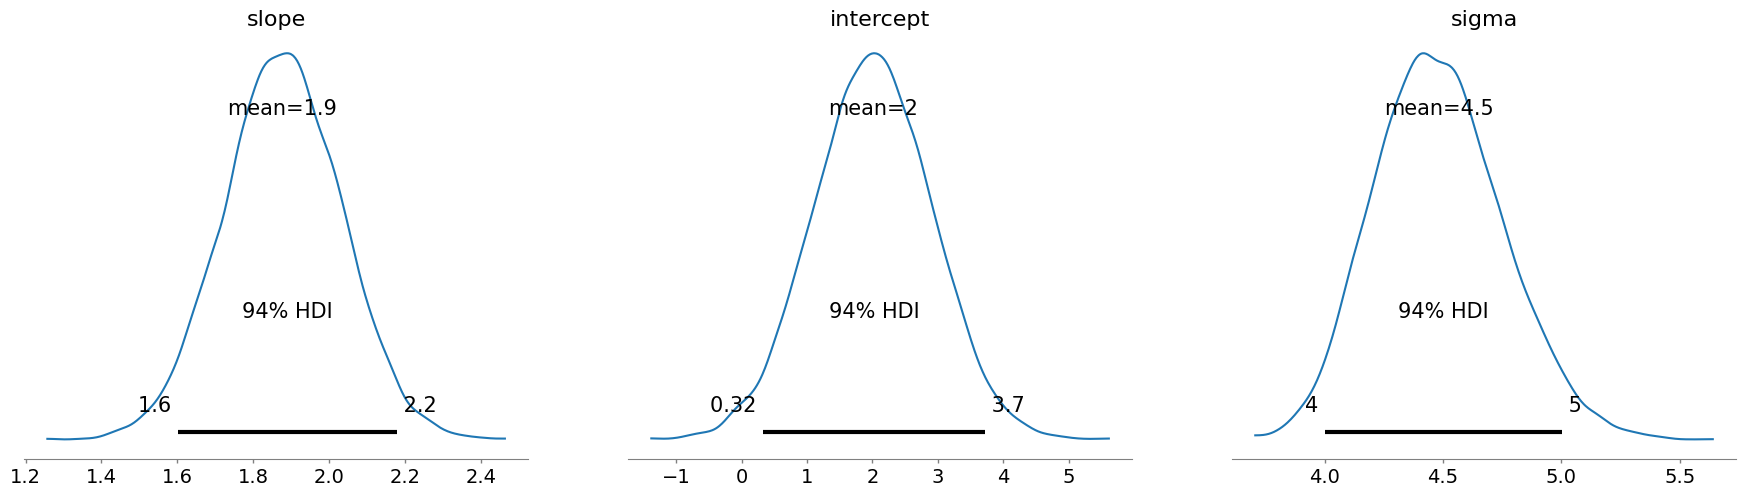

/projects/e21062/tg/venv/lib/python3.7/site-packages/arviz/plots/lmplot.py:209: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/projects/e21062/tg/venv/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


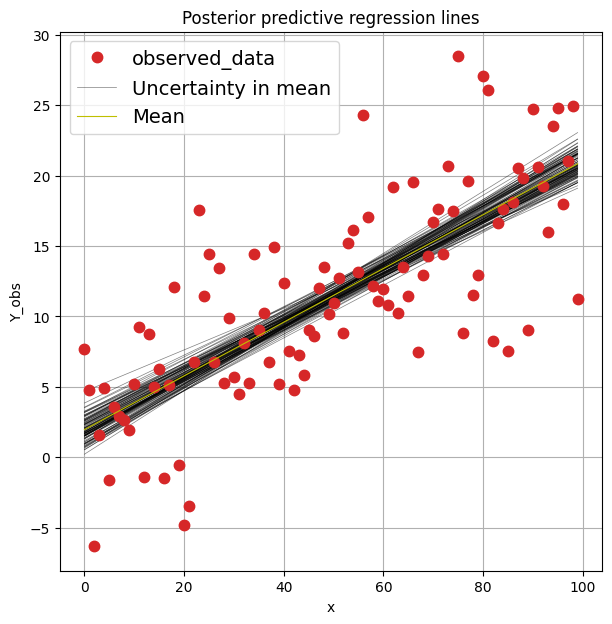

In [3]:
# Generate some sample data
np.random.seed(10)
X = np.linspace(0, 10, 100)
true_slope = 2
true_intercept = 1
Y = true_intercept + true_slope * X + np.random.normal(0, 5, size=100)
 
# Create a PyMC model
with pm.Model() as model:
    # Priors for the parameters
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
 
    # Expected value of the outcome
    mu = intercept + slope * X
 
    # Likelihood (sampling distribution) of the observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
 
    # Run the MCMC sampling
    trace = pm.sample(3000, tune=1000)
 
# Plot the posterior distributions
pm.plot_posterior(trace, var_names=['slope', 'intercept', 'sigma'])
plt.show()

#az.plot_trace(trace, figsize=(10, 7));
trace.posterior["y_model"] = trace.posterior["intercept"] + trace.posterior["slope"] * xr.DataArray(X)

_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace, y="Y_obs", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");


### Beta-Decay Attempt ###

Setup the Bateman equations first generically...

In [4]:
import pandas as pd

def parent(t_parent, a0, x):
    return a0*(np.exp(-((np.log(2))/t_parent)*x));
    
def daughter0n(t_daugh0n, t_parent, a0, branch0n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh0n):
        return a0*(branch0n)*(((np.log(2))/t_daugh0n)/(((np.log(2))/t_daugh0n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh0n)*x)))
    else:
        return a0*(branch0n)*(((np.log(2))/t_daugh0n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh0n)*x)))

def daughter1n(t_daugh1n, t_parent, a0, branch1n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh1n):
        return a0*(branch1n)*(((np.log(2))/t_daugh1n)/(((np.log(2))/t_daugh1n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh1n)*x)))
    else:
        return a0*(branch1n)*(((np.log(2))/t_daugh1n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh1n)*x)))

def daughter2n(t_daugh2n, t_parent, a0, branch2n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh2n):
        return a0*(branch2n)*(((np.log(2))/t_daugh2n)/(((np.log(2))/t_daugh2n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh2n)*x)))
    else:
        return a0*(branch2n)*(((np.log(2))/t_daugh2n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh2n)*x)))

def daughter3n(t_daugh3n, t_parent, a0, branch3n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh3n):
        return a0*(branch3n)*(((np.log(2))/t_daugh3n)/(((np.log(2))/t_daugh3n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh3n)*x)))
    else:
        return a0*(branch3n)*(((np.log(2))/t_daugh3n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh3n)*x)))

def background(bkg, x):
    return bkg

def parentDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + background(bkg, x)

def parent1nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + background(bkg, x)

def parent2nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, branch0n, branch1n, branch2n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + background(bkg, x)

def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n, branch0n, branch1n, branch2n, branch3n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + daughter3n(t_daugh3n, t_parent, a0, branch3n, x) + background(bkg, x)


Setting up for an arbitrary example just to test the analysis etc.

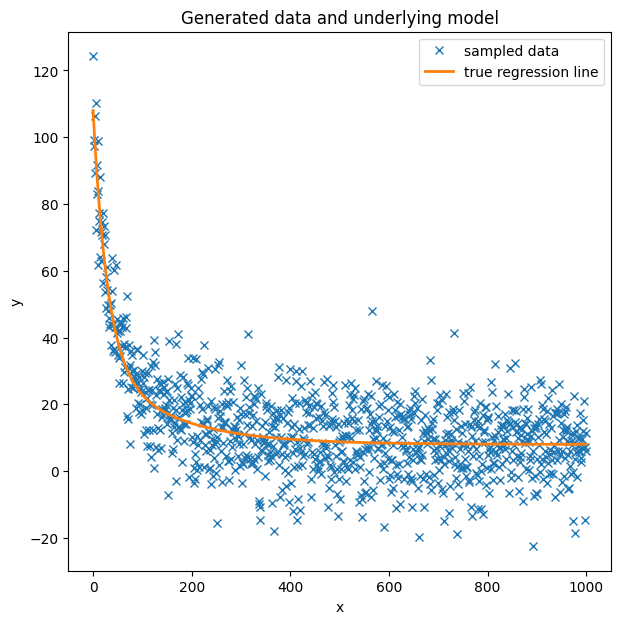

In [5]:
# Generate some sample data
np.random.seed(1)
x = np.linspace(0, 1000, 1000)
parentHalf = 20
daughter0nHalf = 100
a0 = 100
branch0n = 1
backgroundLevel = 8
y = parent1nDaughterLinear(a0, parentHalf, daughter0nHalf, 1000, branch0n, 0., backgroundLevel, x) + np.random.normal(0, 10, size=1000)
trueFit = parent1nDaughterLinear(a0, parentHalf, daughter0nHalf, 1000, branch0n, 0., backgroundLevel, x)

data = pd.DataFrame(dict(x=x, y=y))
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, trueFit, label="true regression line", lw=2.0)
plt.legend(loc=0);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, initialActivity, branch0n, branch1n, backgroundLevel, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 38 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961, but should be close to 0.8. Try to increase the number of tuning steps.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6691, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5786, but should be close to 0.8. Try to increase the number of tuning steps.


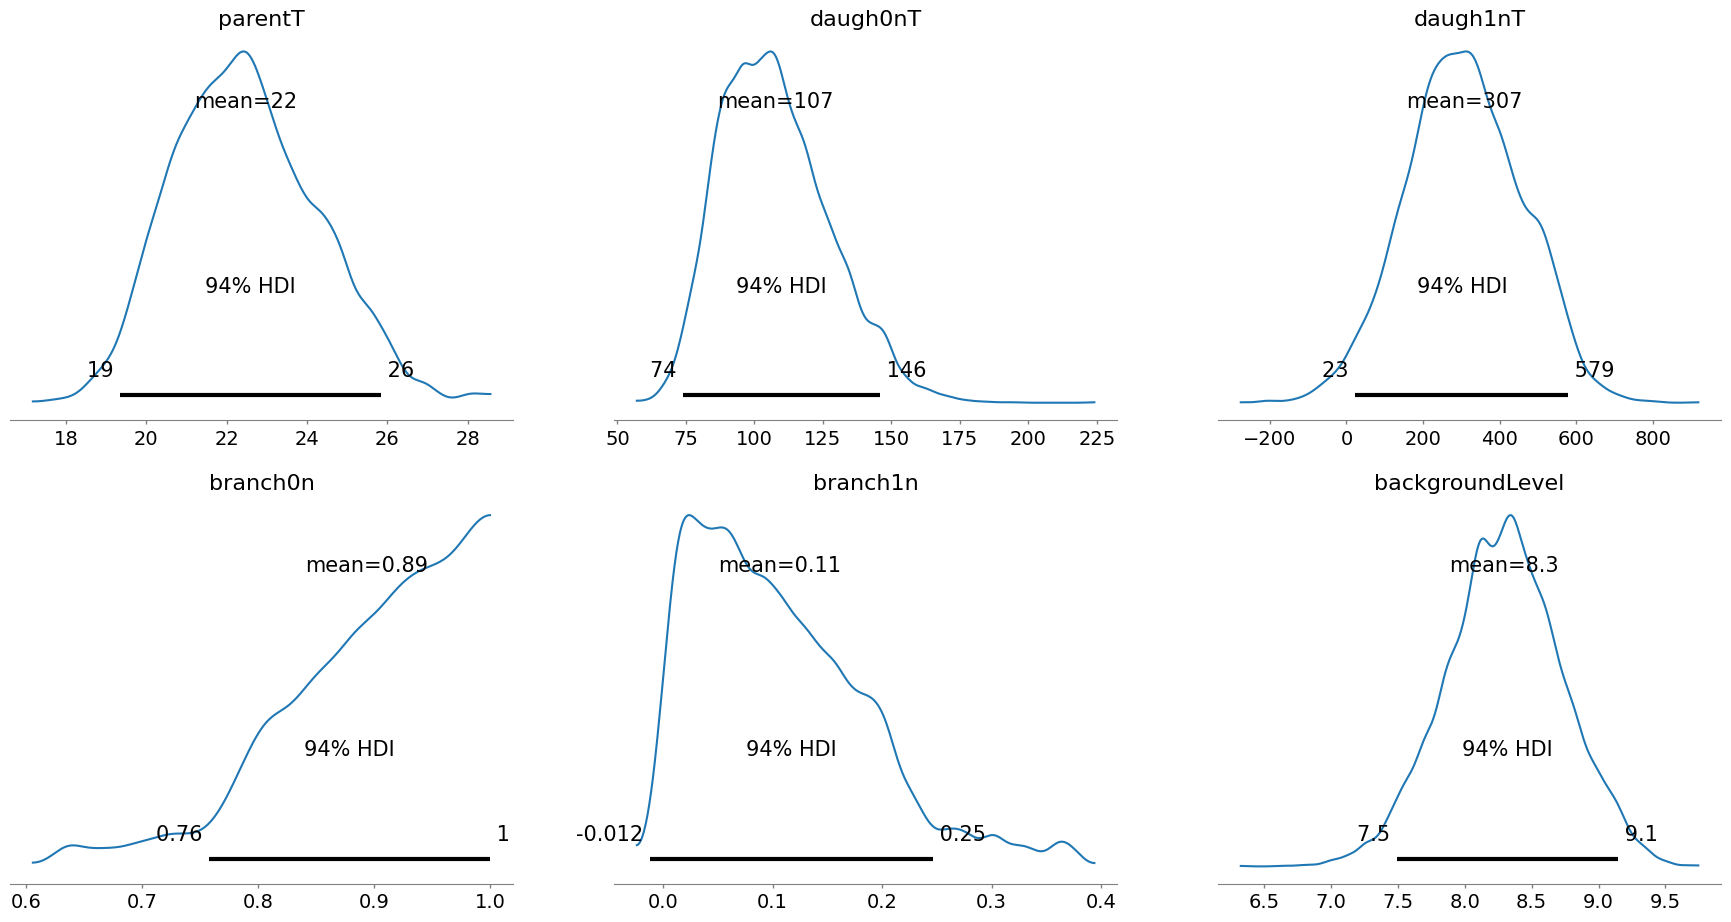

In [6]:
# Create a PyMC model
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=30, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=80, sigma=40)
    daughter1nThalf = pm.Normal('daugh1nT', mu=300, sigma=150)
    initialActivity = pm.Normal('initialActivity', mu=100, sigma=30)
    branch0n = pm.Uniform('branch0n', 0., 1.)
    #branch1n = pm.Uniform('branch1n', 0, (1.-branch0n))
    branch1n = pm.Normal('branch1n', mu=(1.-branch0n), sigma=0.01)
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of the outcome
    mu = parentDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, branch0n, branch1n, backgroundLevel, x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
 
    # Run the MCMC sampling
    trace = pm.sample(3000, tune=1000)
 
# Plot the posterior distributions
pm.plot_posterior(trace, var_names=['parentT', 'daugh0nT', 'daugh1nT', 'branch0n', 'branch1n', 'backgroundLevel'])
plt.show()


array([[<AxesSubplot:ylabel='daugh0nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='initialActivity'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='branch1n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='parentT', ylabel='branch0n'>,
        <AxesSubplot:xlabel='daugh0nT'>,
        <AxesSubplot:xlabel='initialActivity'>,
        <AxesSubplot:xlabel='branch1n'>]], dtype=object)

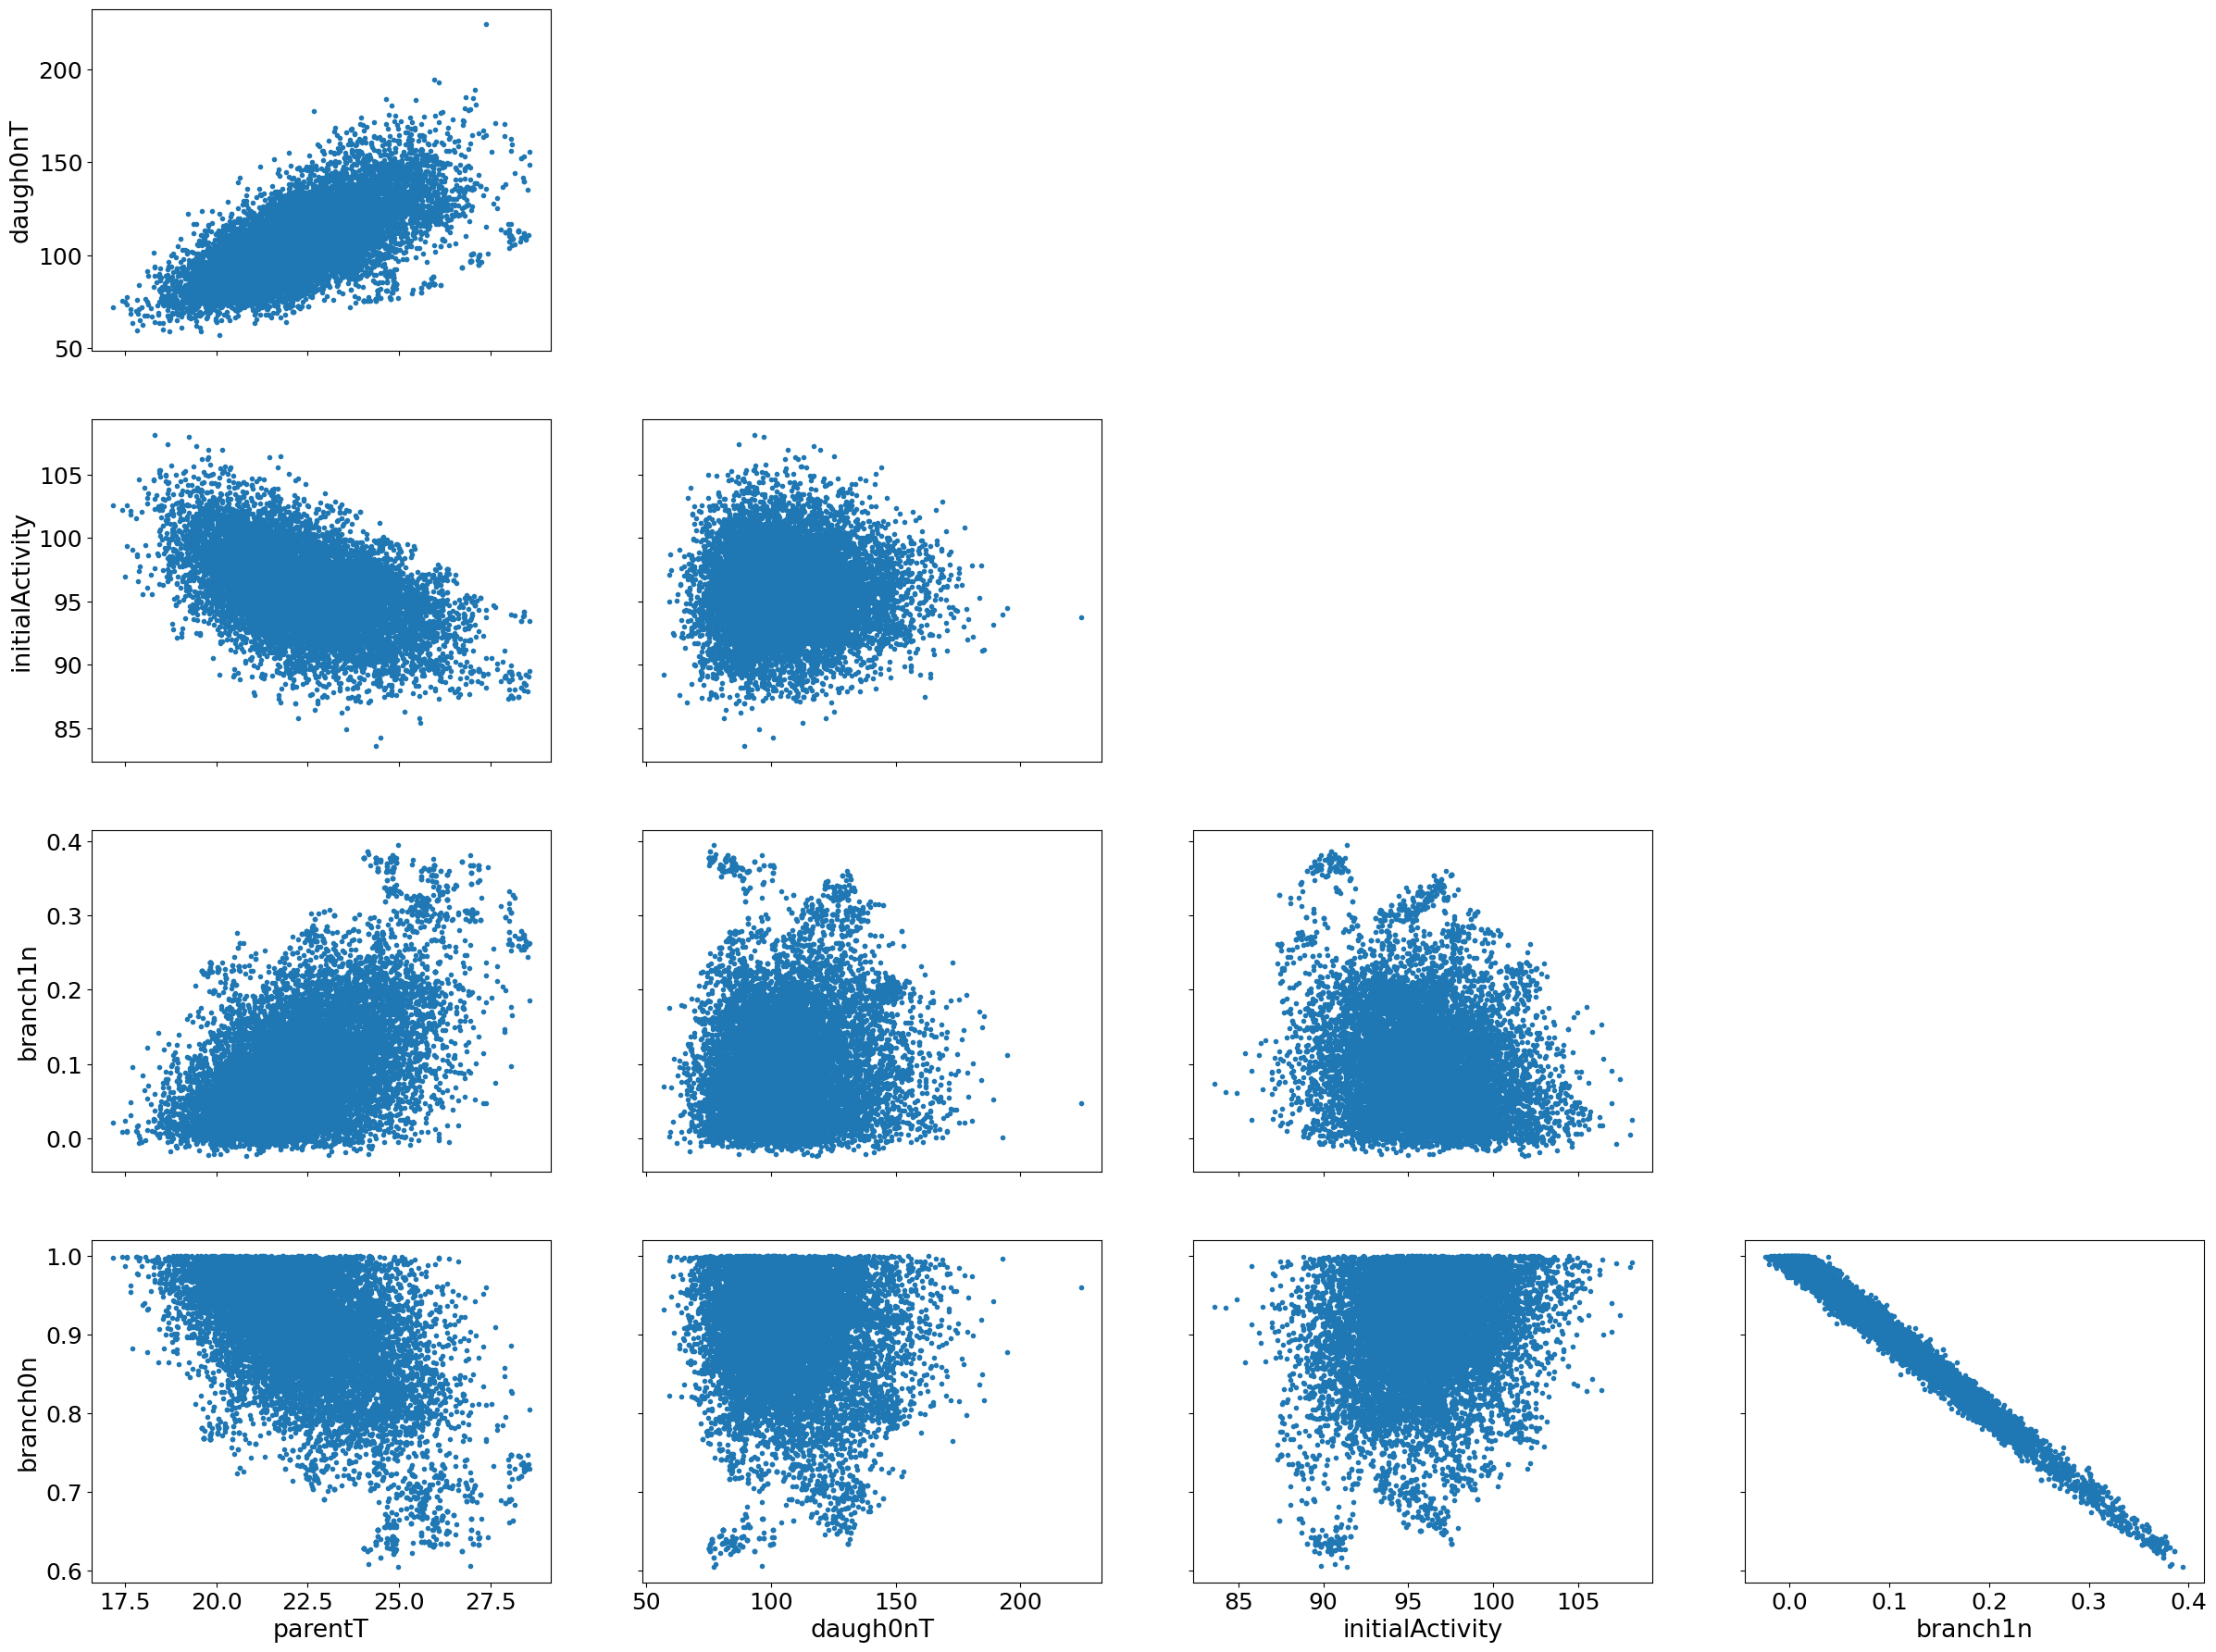

In [7]:
az.plot_pair(trace, var_names=['initialActivity', 'daugh0nT', 'parentT', 'branch0n', 'branch1n'],
            filter_vars="regex",
            divergences=False,
            textsize=18)

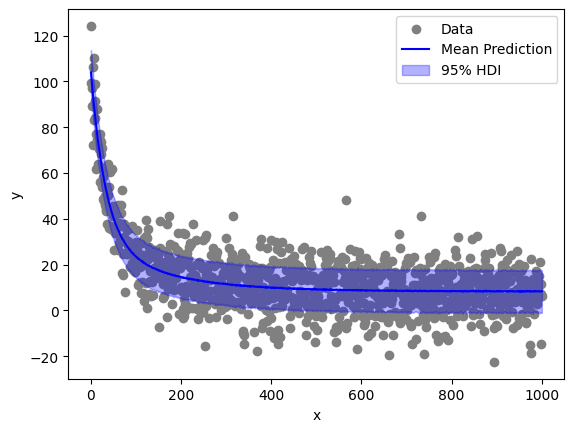

In [8]:
ppc = pm.sample_posterior_predictive(trace, model=model).posterior_predictive
y_pred = np.mean(ppc['y_obs'], axis=0)

y_mean = np.mean(y_pred, axis=0)

y_hdi_lower, y_hdi_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)

# Plot the data points
plt.scatter(x, y, color='grey', label='Data')

# Plot the mean prediction
plt.plot(x, y_mean, color='blue', label='Mean Prediction')

# Plot the HDI intervals as error bars
plt.fill_between(x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 31F Fitting ###
Real analysis for the case of 31F first.

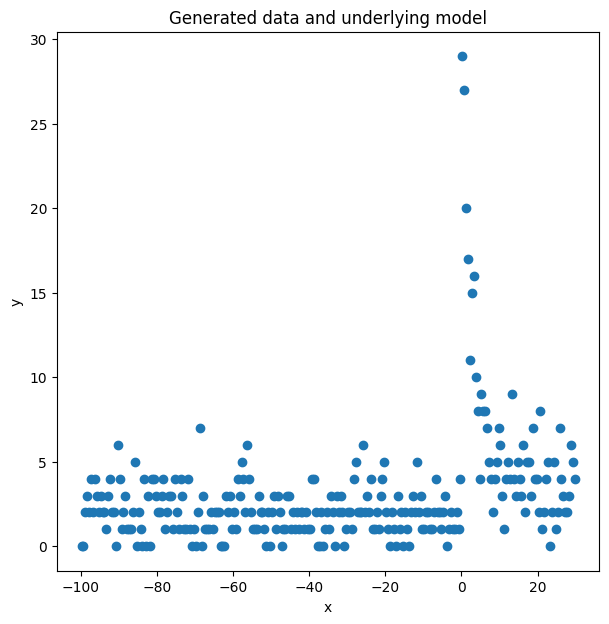

In [131]:
df31F = pd.read_csv('hist_31F.csv')
# Filter to only include 0 <= x <= 100
df31F = df31F[(df31F["xVal"] >= -100) & (df31F["xVal"] <= 30)]
x = df31F["xVal"]
y = df31F["yVal"]

fig31F = plt.figure(figsize=(7, 7))
ax2 = fig31F.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax2.plot(x, y, "o", label="Data")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [bkg_amp, bkg_lambda, sigma_bkg]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 7 seconds.
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1119: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  FutureWarning,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1128: UserWarning: Softmax no longer converts a vector to a row matrix.
  UserWarning,


Background parameters: 2.079974206734541 0.0008784688783744532


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 64 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, theta, bkg_amp, bkg_lambda, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 108 seconds.
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
There were 531 divergences after tuning. Increase `target_accept` or reparameterize.
There were 529 divergences after tuning. Increase `target_accept` or reparameterize.
There were 480 divergences after tuning. Increase `target_accept` or reparameterize.


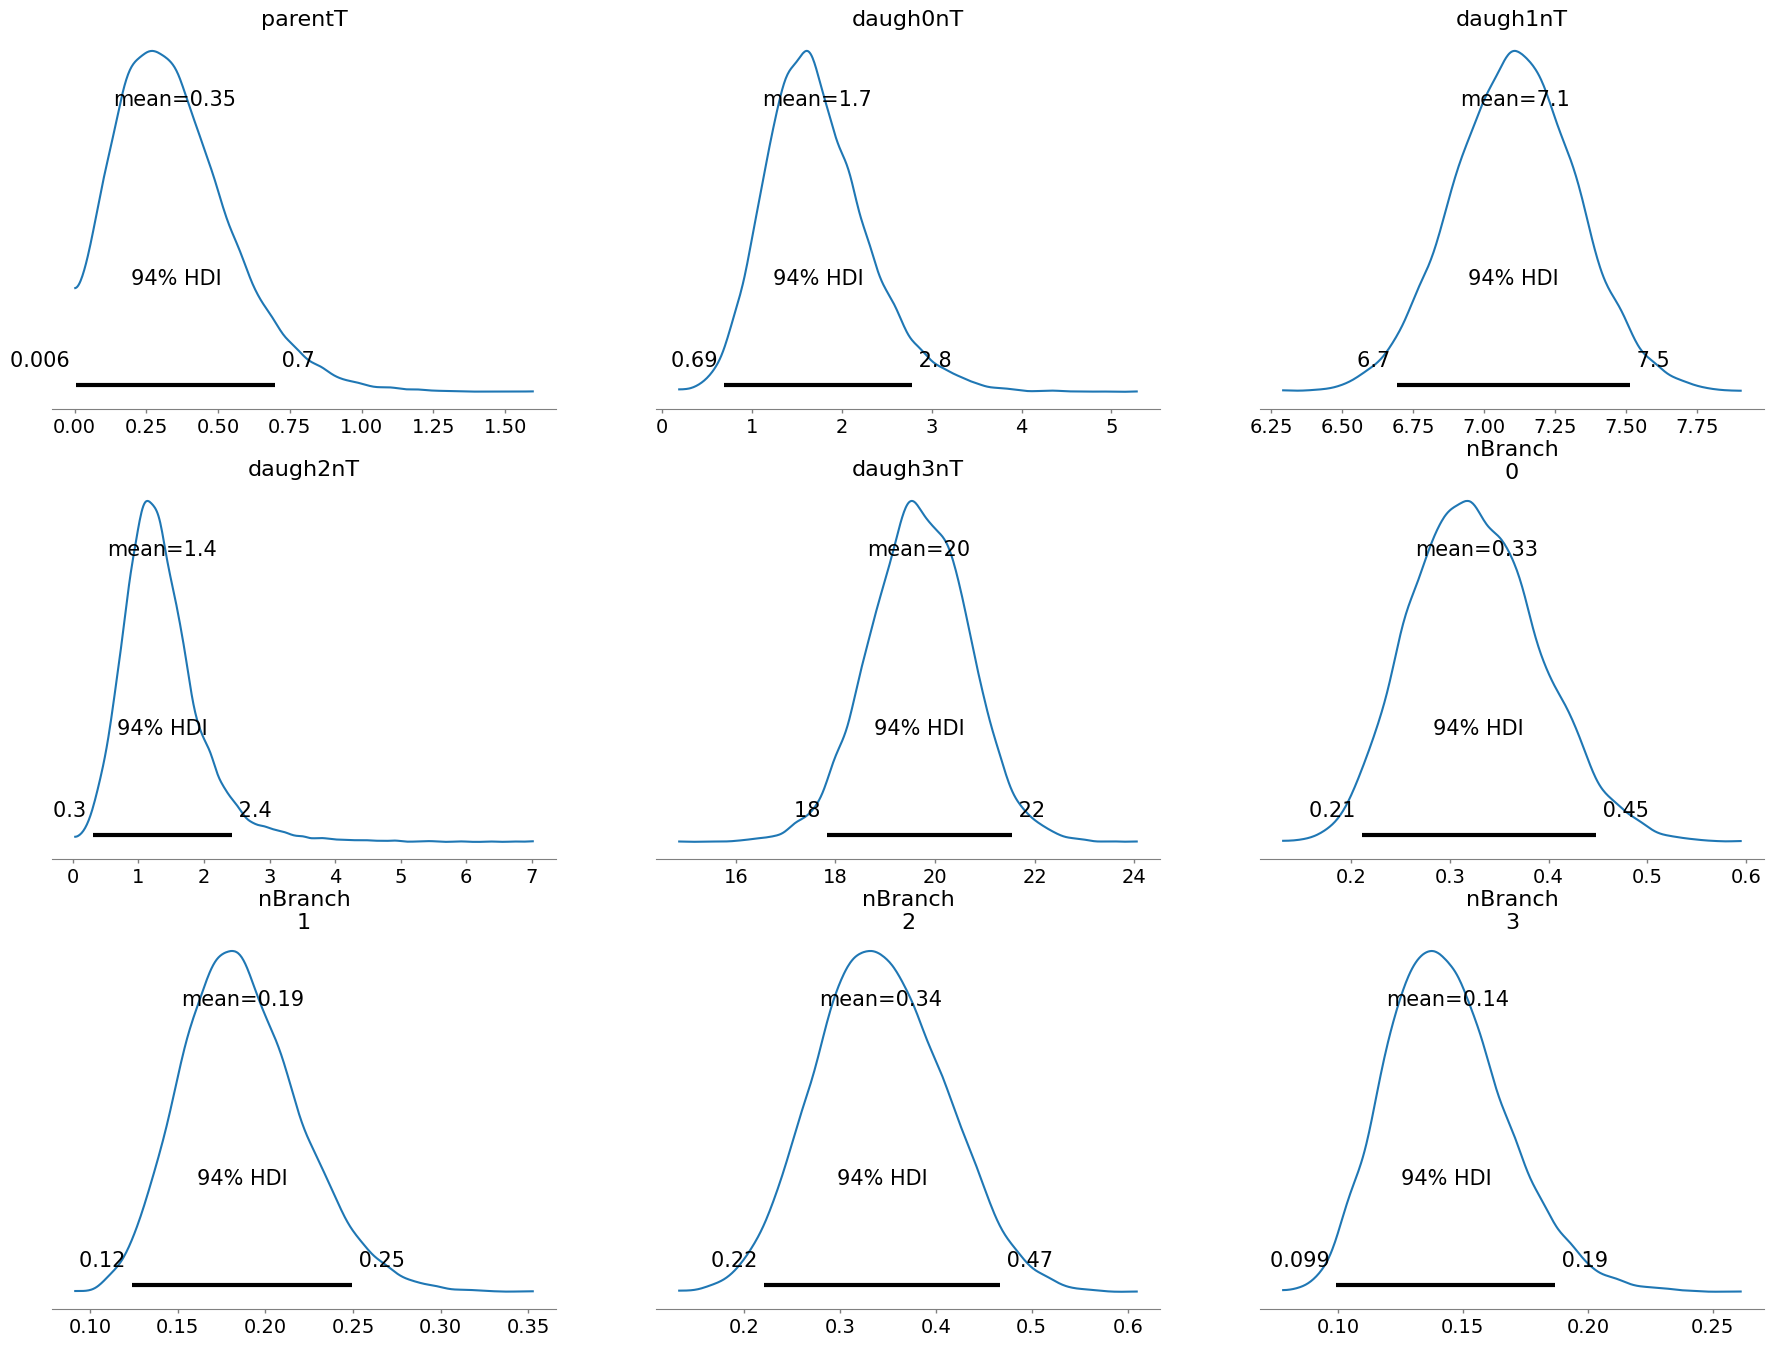

In [134]:



# Split data
pre_x = x[x < 0]
pre_y = y[x < 0]
decay_x = x[x >= 0]
decay_y = y[x >= 0]

# --- Step 1: Fit background model on pre-decay region ---
with pm.Model() as bkg_model:
    bkg_amp = pm.HalfNormal('bkg_amp', sigma=50)
    bkg_lambda = pm.HalfNormal('bkg_lambda', sigma=0.1)

    bkg_mu = bkg_amp * pm.math.exp(bkg_lambda * pre_x)

    sigma_bkg = pm.HalfNormal('sigma_bkg', sigma=5)
    y_bkg_obs = pm.Normal('y_bkg_obs', mu=bkg_mu, sigma=sigma_bkg, observed=pre_y)

    trace_bkg = pm.sample(3000, tune=1000, target_accept=0.98, chains=2)

# Extract background fit means
bkg_amp_mean = np.mean(trace_bkg.posterior['bkg_amp'].stack(draws=("chain", "draw")).values)
bkg_lambda_mean = np.mean(trace_bkg.posterior['bkg_lambda'].stack(draws=("chain", "draw")).values)

# --- Step 2: Define decay model + exponential background ---

# Define the total decay function (no background inside!)
def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n,
                           branch0n, branch1n, branch2n, branch3n, background, x):
    return (
        parent(t_parent, a0, x)
        + daughter0n(t_daugh0n, t_parent, a0, branch0n, x)
        + daughter1n(t_daugh1n, t_parent, a0, branch1n, x)
        + daughter2n(t_daugh2n, t_parent, a0, branch2n, x)
        + daughter3n(t_daugh3n, t_parent, a0, branch3n, x)
    )

with pm.Model() as model:
    # Priors for decay and activity
    parentThalf = pm.Normal('parentT', mu=5, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=3.4, sigma=0.8)
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.18, sigma=0.22)
    daughter2nThalf = pm.Normal('daugh2nT', mu=15, sigma=3)
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma=1)
    initialActivity = pm.Normal('initialActivity', mu=30, sigma=20)

    # Branching ratios
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    #nBranch = pm.Dirichlet('nBranch', a=np.array([1e-6, 63, 17, 20]))
    target_softmax = np.array([0.25, 0.25, 0.25, 0.25])
    theta_mu = np.log(target_softmax)
    theta = pm.Normal('theta', mu=theta_mu, sigma=0.2, shape=4)
    nBranch = pm.Deterministic('nBranch', at.nnet.softmax(theta))
    #nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])

    # Background with priors from previous fit
    bkg_amp = pm.Normal('bkg_amp', mu=bkg_amp_mean, sigma=5)
    bkg_lambda = pm.Normal('bkg_lambda', mu=bkg_lambda_mean, sigma=0.05)
    print("Background parameters:", bkg_amp_mean, bkg_lambda_mean)
    background = pm.Deterministic('background', bkg_amp_mean * pm.math.exp(bkg_lambda_mean * decay_x))

    # Decay model
    decay_mu = parent3nDaughterLinear(
        initialActivity,
        parentThalf,
        daughter0nThalf,
        daughter1nThalf,
        daughter2nThalf,
        daughter3nThalf,
        nBranch[0], nBranch[1], nBranch[2], nBranch[3],
        background,
        decay_x
    )

    # Total model
    mu = pm.Deterministic('mu', decay_mu + background)

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Likelihood
    y_obs31F = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y)

    # Sampling
    trace31F = pm.sample(3000, tune=1000, target_accept=0.995, chains=4, cores=multiprocessing.cpu_count())

# --- Step 3: Posterior plots ---
pm.plot_posterior(trace31F, var_names=[
    'parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT',
    'nBranch'
])
plt.show()


In [ ]:
df31F = pd.read_csv('hist_31F.csv')

# Filter to only include 0 <= x <= 100
df31F = df31F[(df31F["xVal"] >= 0) & (df31F["xVal"] <= 100)]

x = df31F["xVal"]
y = df31F["yVal"]

fig31F = plt.figure(figsize=(7, 7))
ax2 = fig31F.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax2.plot(x, y, "o", label="Data")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, nBranch, backgroundLevel, sigma]


Sampling 4 chains for 1_000 tune and 2_655 draw iterations (4_000 + 10_620 draws total) took 69 seconds.
There were 1579 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3411, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 6.035e-24, but should be close to 0.8. Try to increase the number of tuning steps.


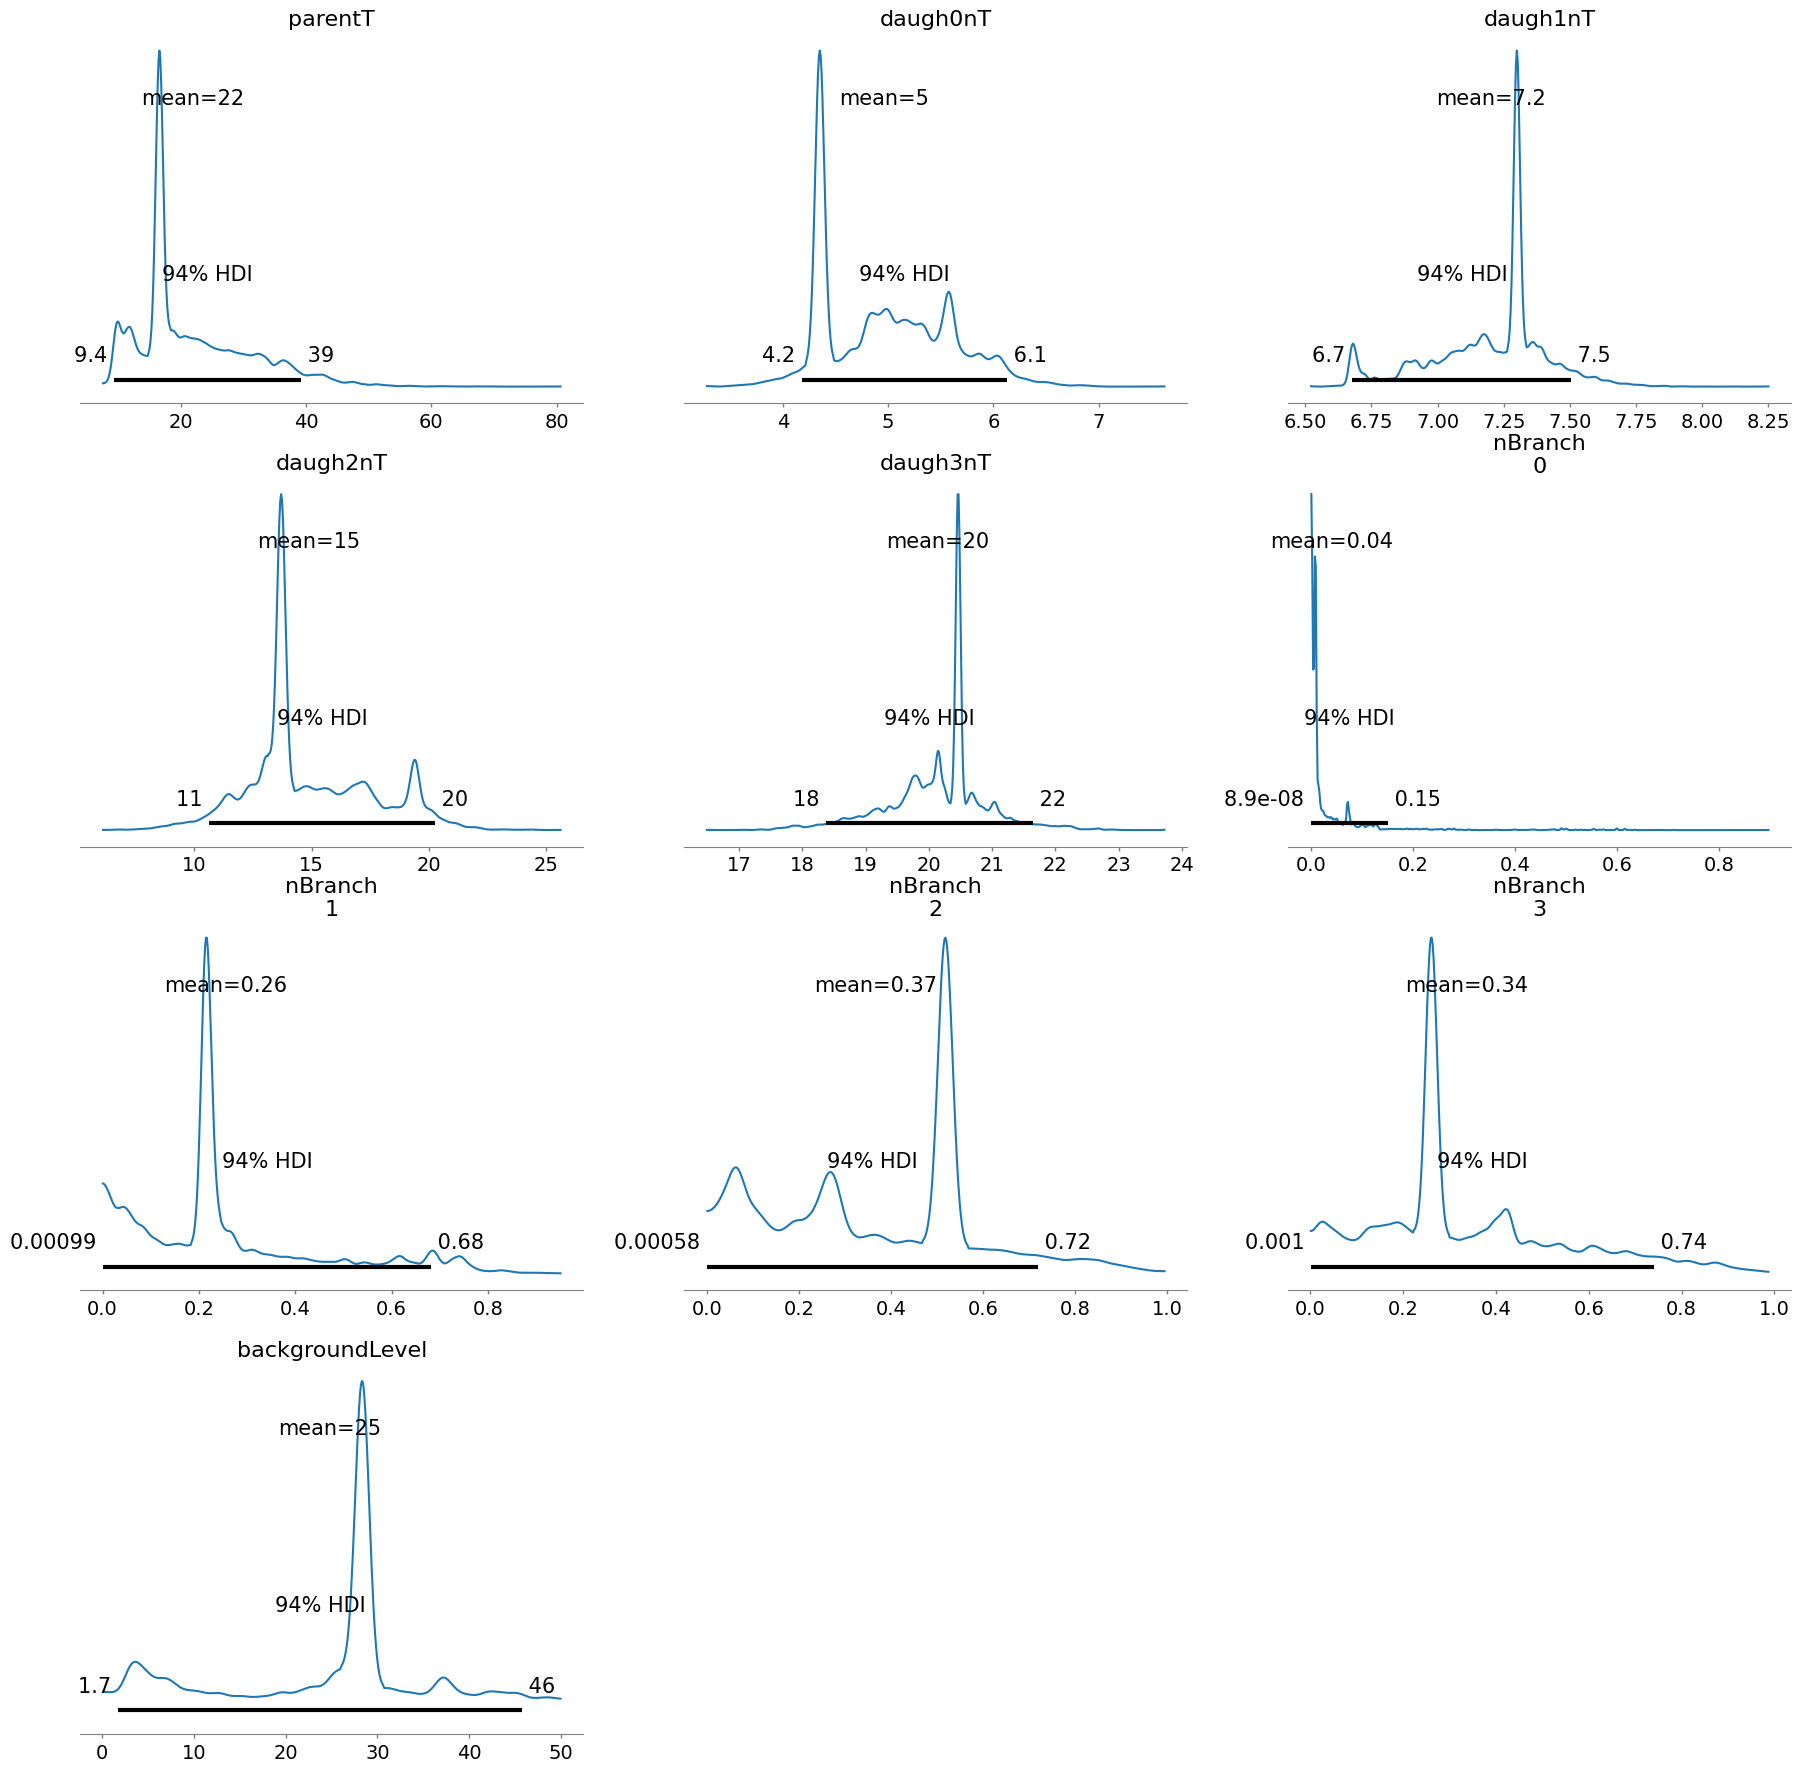

In [136]:
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=5, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=3.4, sigma=0.8) # 31Ne T1/2 = 3.4(8)ms
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.18, sigma=0.22) # 30Ne T1/2 = 7.18(22)ms
    daughter2nThalf = pm.Normal('daugh2nT', mu=15, sigma = 3) # 29Ne T1/2 = 15(3) ms
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma = 1) # 28Ne T1/2 = 20(1) ms
    initialActivity = pm.Normal('initialActivity', mu=30, sigma=20)
    #branch0n = pm.Uniform('branch0n', 0., 0.1)
    #branch1n = pm.Uniform('branch1n', 0., (1.-branch0n))
    #branch2n = pm.Uniform('branch2n', 0., (1.-branch0n-branch1n))
    #branch3n = pm.Normal('branch3n', mu=(1.-branch0n-branch1n-branch2n), sigma=0.01)
    # nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])
    
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Expected value of the outcome
    mu = parent3nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, daughter3nThalf, nBranch[0], nBranch[1], nBranch[2], nBranch[3], backgroundLevel, x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs31F = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
 
    # Run the MCMC sampling
    #model.debug()
    trace31F = pm.sample(3000, tune=1000)

# Plot the posterior distributions

pm.plot_posterior(trace31F, var_names=['parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT', 'nBranch', 'backgroundLevel'])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (60,) and (260,)

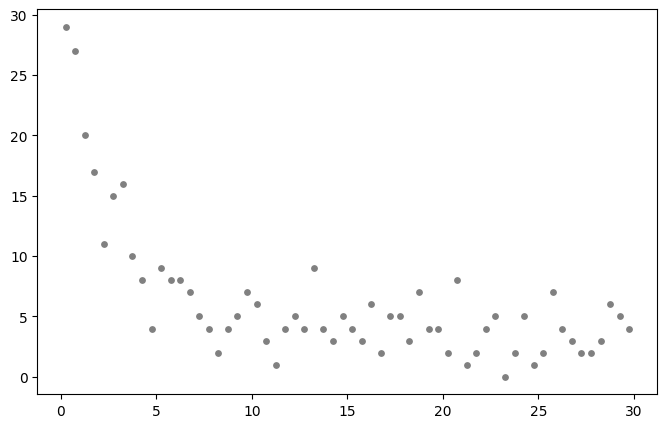

In [137]:


# Posterior Predictive Sampling
ppc = pm.sample_posterior_predictive(trace31F, model=model, progressbar=False)
y_pred_samples = ppc.posterior_predictive['y_obs'].stack(draws=("chain", "draw")).values.T


# Compute summary stats
y_mean = np.mean(y_pred_samples, axis=0)
y_std = np.std(y_pred_samples, axis=0)
y_hdi_lower, y_hdi_upper = np.percentile(y_pred_samples, [2.5, 97.5], axis=0)

# -----------------------------
# 📈 Figure 1: Posterior Predictive Plot
# -----------------------------
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(decay_x, decay_y, color='grey', s=15, label='Observed data')
ax1.plot(decay_x, y_mean, color='blue', label='Mean prediction')
ax1.fill_between(decay_x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')
ax1.set_title('Posterior Predictive with 95% HDI')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid(True)

# -----------------------------
# 📉 Figure 2: Normalized Residuals
# -----------------------------
residuals = (decay_y - y_mean) / y_std

fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.plot(decay_x, residuals, marker='o', linestyle='', color='red', label='Normalized residuals')
ax2.set_title('Normalized Residuals')
ax2.set_xlabel('x')
ax2.set_ylabel('Residual (y - μ) / σ')
ax2.grid(True)
ax2.legend()

plt.show()


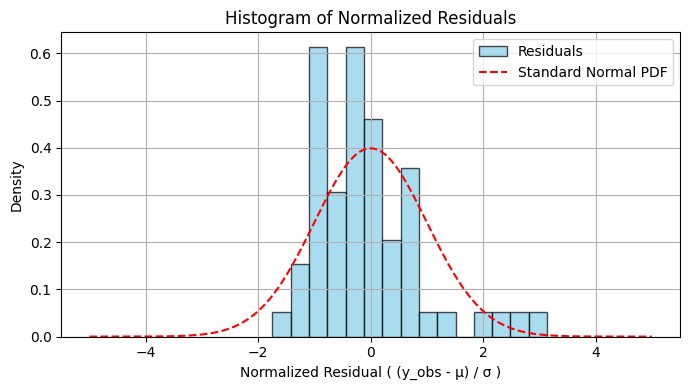

In [69]:

# Already computed earlier:
# residuals = (decay_y - y_mean) / y_std

# 1D histogram of residuals
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=15, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Residuals')

# Plot a standard normal distribution for comparison
from scipy.stats import norm
x_vals = np.linspace(-5, 5, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'r--', label='Standard Normal PDF')

plt.title("Histogram of Normalized Residuals")
plt.xlabel("Normalized Residual ( (y_obs - μ) / σ )")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


array([[<AxesSubplot:ylabel='daugh0nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh1nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh2nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh3nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubp

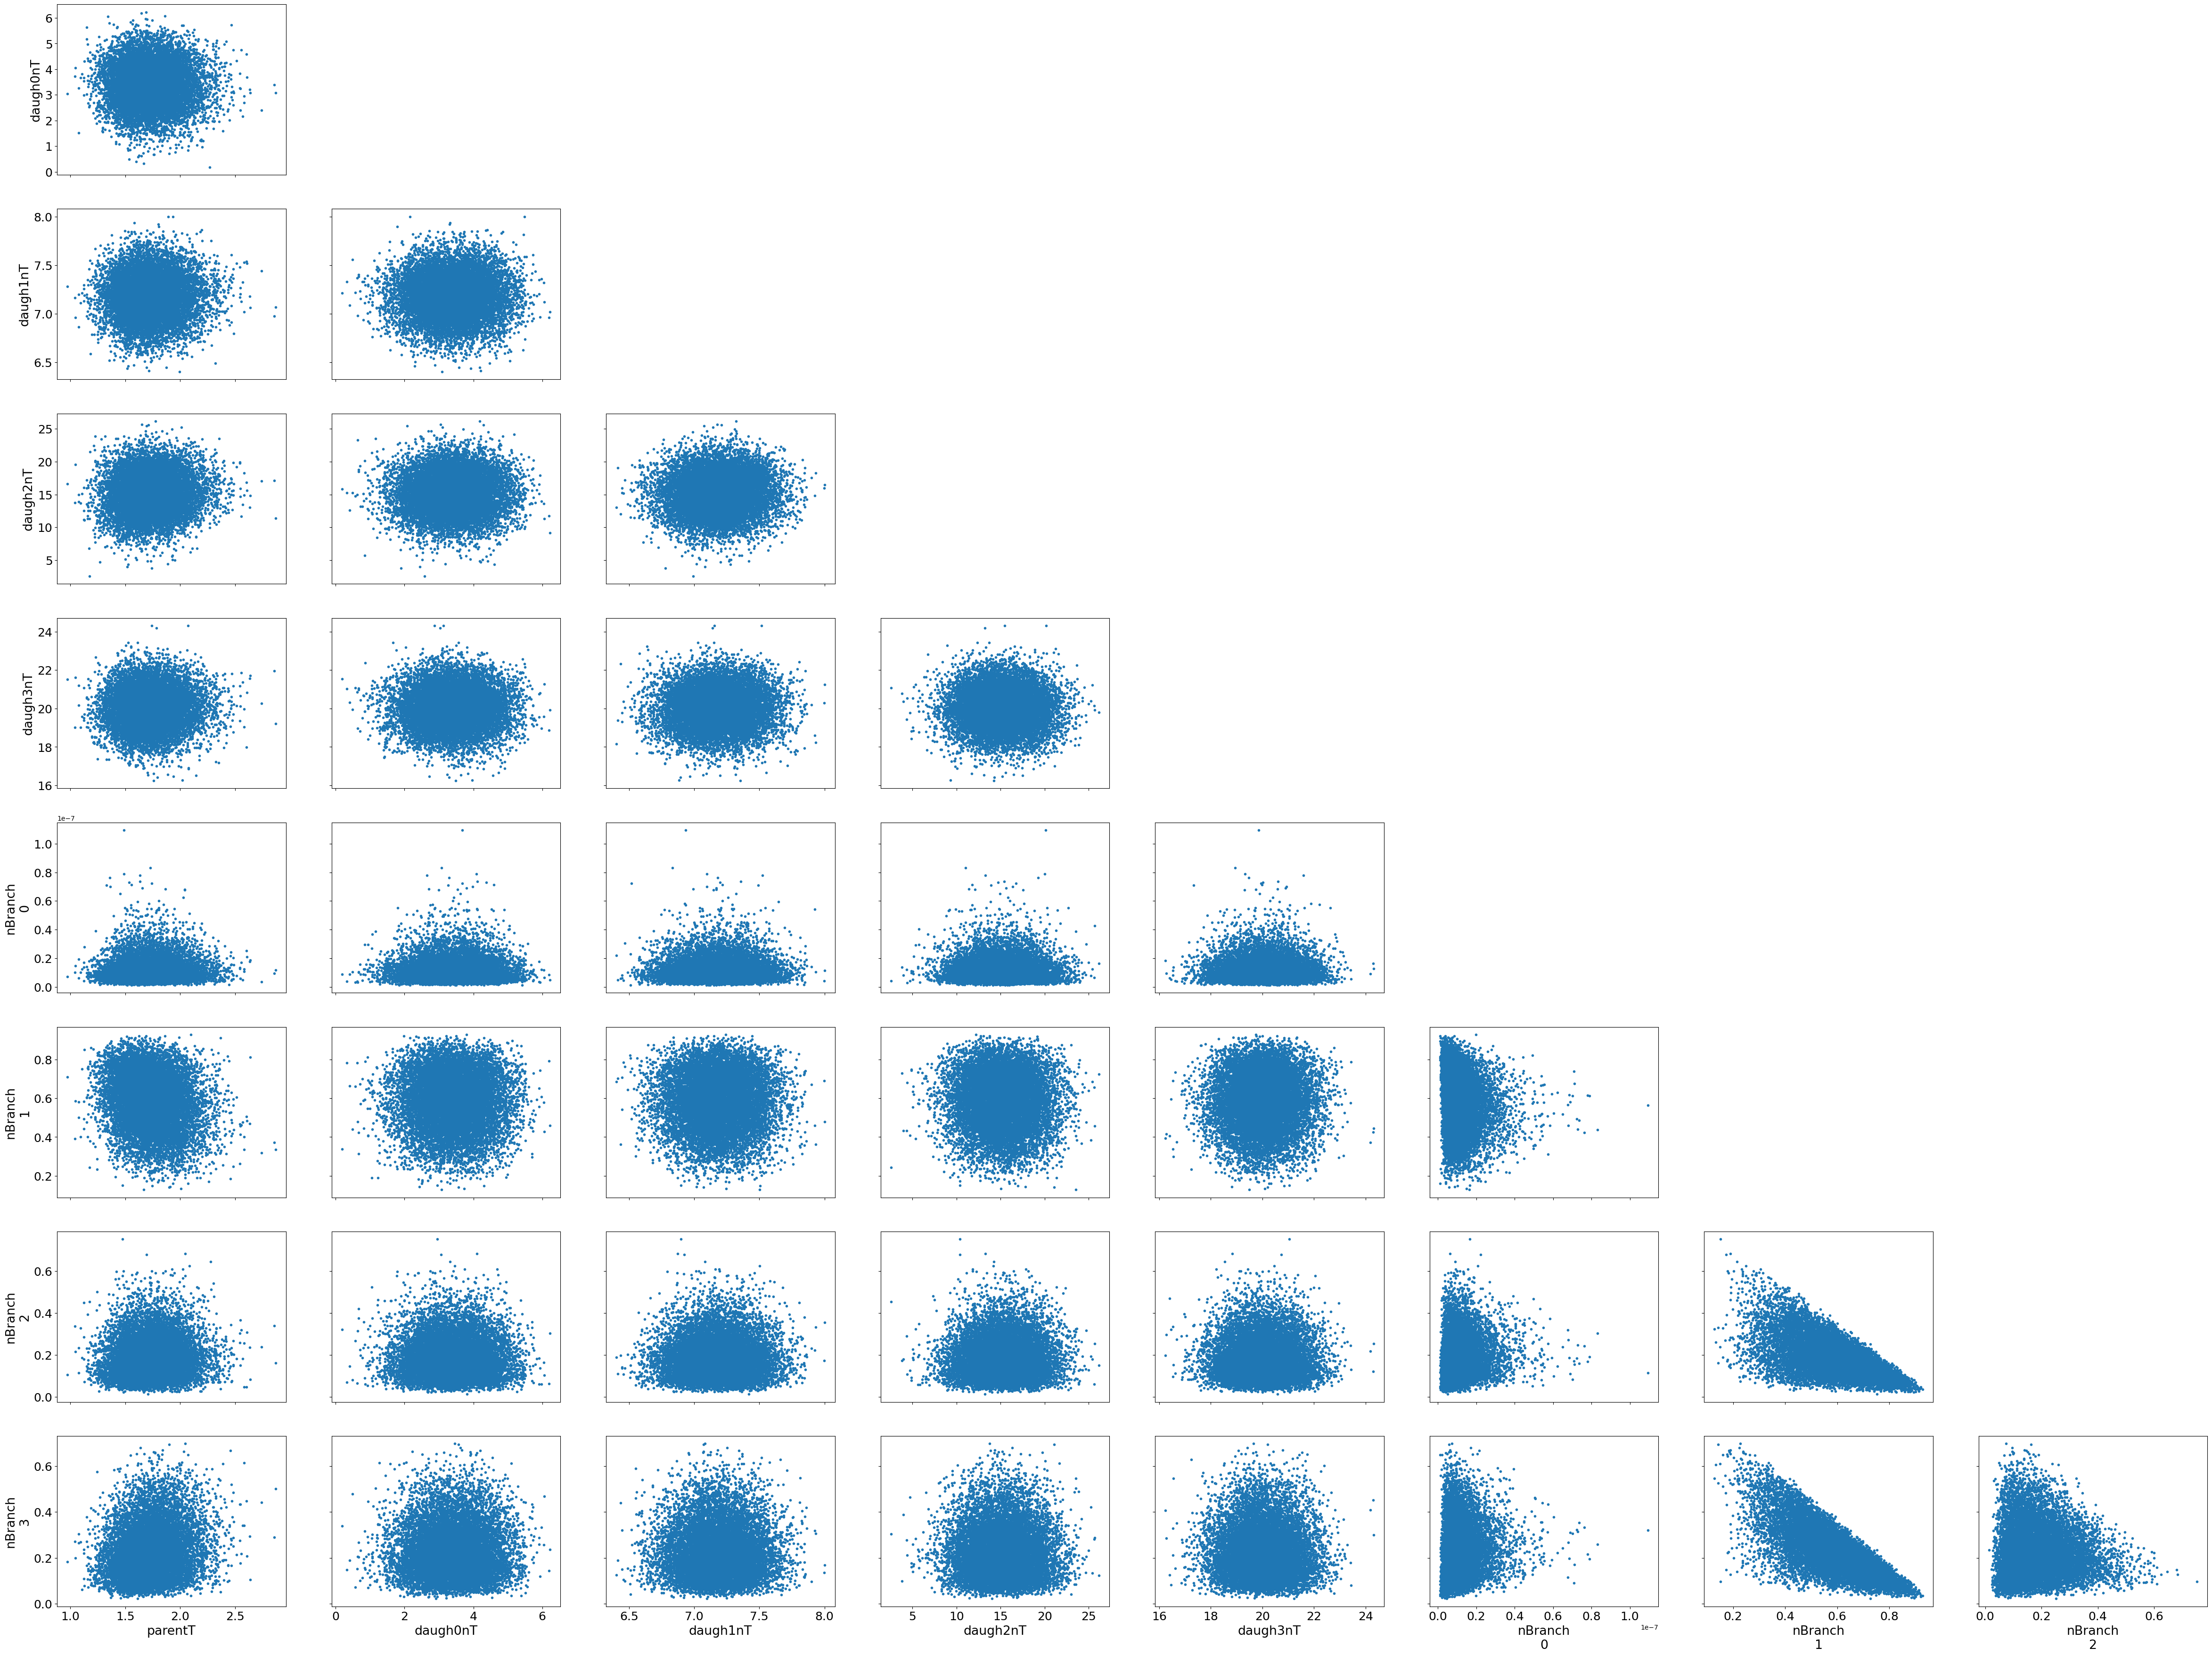

In [70]:
az.plot_pair(trace31F, var_names=['parentT', 'daugh2nT', 'daugh3nT', 'daugh1nT', 'daugh0nT', 'nBranch'],
            filter_vars="regex",
            divergences=False,
            textsize=18)

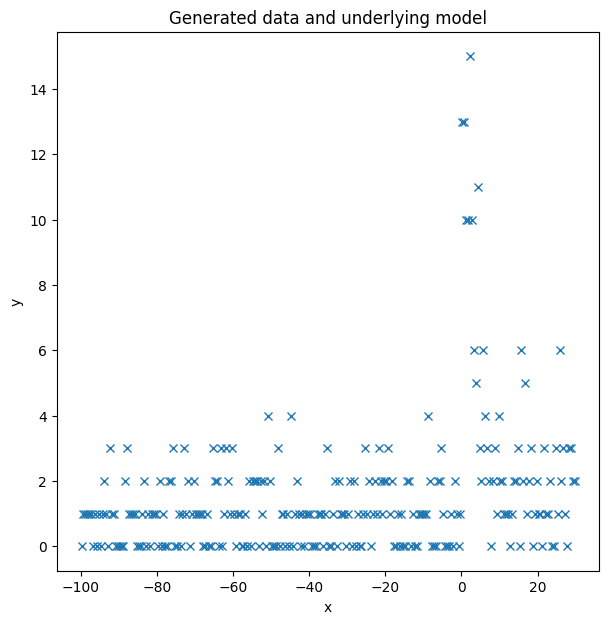

In [71]:
df37Na = pd.read_csv('hist_37Na.csv')
# Filter to only include 0 <= x <= 100
df37Na = df37Na[(df37Na["xVal"] >= -100) & (df37Na["xVal"] <= 30)]
x = df37Na["xVal"]
y = df37Na["yVal"]

fig37Na = plt.figure(figsize=(7, 7))
ax2 = fig37Na.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax2.plot(x, y, "x", label="Data")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [bkg_amp, bkg_lambda, sigma_bkg]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 8 seconds.
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1119: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  FutureWarning,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1128: UserWarning: Softmax no longer converts a vector to a row matrix.
  UserWarning,


1.136056508429035 0.002868701636472277


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 64 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, theta, bkg_amp, bkg_lambda, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 33 seconds.


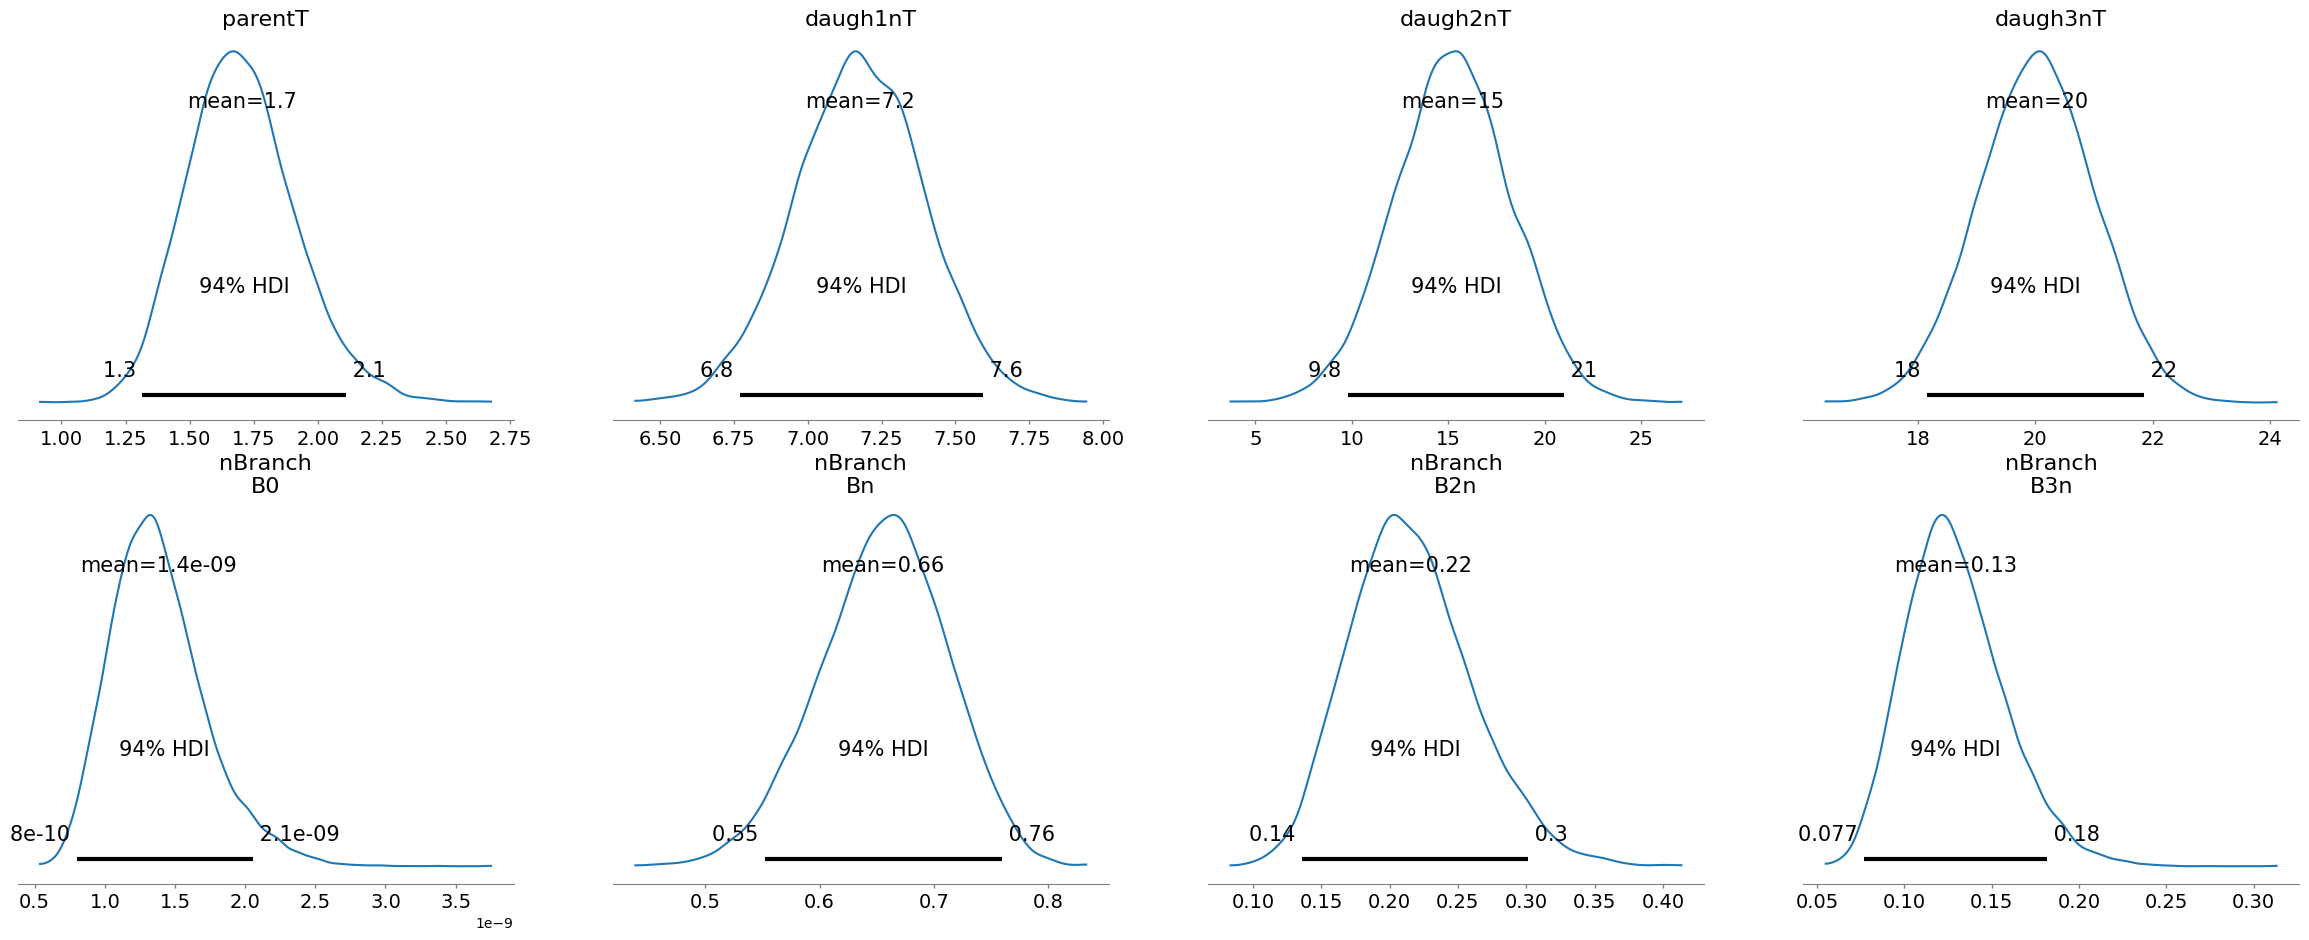

In [ ]:
import multiprocessing
import aesara.tensor as at


# Split data
pre_x = x[x < 0]
pre_y = y[x < 0]
decay_x = x[x >= 0]
decay_y = y[x >= 0]

# --- Step 1: Fit background model on pre-decay region ---
with pm.Model() as bkg_model:
    bkg_amp = pm.HalfNormal('bkg_amp', sigma=50)
    bkg_lambda = pm.HalfNormal('bkg_lambda', sigma=0.1)

    bkg_mu = bkg_amp * pm.math.exp(bkg_lambda * pre_x)

    sigma_bkg = pm.HalfNormal('sigma_bkg', sigma=5)
    y_bkg_obs = pm.Normal('y_bkg_obs', mu=bkg_mu, sigma=sigma_bkg, observed=pre_y)

    trace_bkg = pm.sample(3000, tune=1000, target_accept=0.98, chains=2)

# Extract background fit means
bkg_amp_mean = np.mean(trace_bkg.posterior['bkg_amp'].stack(draws=("chain", "draw")).values)
bkg_lambda_mean = np.mean(trace_bkg.posterior['bkg_lambda'].stack(draws=("chain", "draw")).values)

# --- Step 2: Define decay model + exponential background ---

# Define the total decay function (no background inside!)
def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n,
                           branch0n, branch1n, branch2n, branch3n, background, x):
    return (
        parent(t_parent, a0, x)
        + daughter0n(t_daugh0n, t_parent, a0, branch0n, x)
        + daughter1n(t_daugh1n, t_parent, a0, branch1n, x)
        + daughter2n(t_daugh2n, t_parent, a0, branch2n, x)
        + daughter3n(t_daugh3n, t_parent, a0, branch3n, x)
    )

with pm.Model() as model:
    # Priors for decay and activity
    parentThalf = pm.Normal('parentT', mu=5, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=3.4, sigma=0.8)
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.18, sigma=0.22)
    daughter2nThalf = pm.Normal('daugh2nT', mu=15, sigma=3)
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma=1)
    initialActivity = pm.Normal('initialActivity', mu=30, sigma=20)

    # Branching ratios
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    #theta = pm.Normal('theta', mu=0, sigma=0.2, shape=4)
    #nBranch = pm.Deterministic('nBranch', at.nnet.softmax(theta))
    target_softmax = np.array([0.25, 0.25, 0.25, 0.25])
    theta_mu = np.log(target_softmax)
    theta = pm.Normal('theta', mu=theta_mu, sigma=0.2, shape=4)
    nBranch = pm.Deterministic('nBranch', at.nnet.softmax(theta))
    #nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])

    # Background with priors from previous fit
    bkg_amp = pm.Normal('bkg_amp', mu=bkg_amp_mean, sigma=5)
    bkg_lambda = pm.Normal('bkg_lambda', mu=bkg_lambda_mean, sigma=0.05)
    print(bkg_amp_mean, bkg_lambda_mean)
    background = pm.Deterministic('background', bkg_amp_mean * pm.math.exp(bkg_lambda_mean * decay_x))

    # Decay model
    decay_mu = parent3nDaughterLinear(
        initialActivity,
        parentThalf,
        daughter0nThalf,
        daughter1nThalf,
        daughter2nThalf,
        daughter3nThalf,
        nBranch[0], nBranch[1], nBranch[2], nBranch[3],
        background,
        decay_x
    )

    # Total model
    mu = pm.Deterministic('mu', decay_mu + background)

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Likelihood
    y_obs37Na = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y)

    # Sampling
    trace37Na = pm.sample(3000, tune=1000, target_accept=0.995, chains=4, cores=multiprocessing.cpu_count())
trace37Na = trace37Na.assign_coords(nBranch_dim_0=["B0", "Bn", "B2n", "B3n"])
pm.plot_posterior(trace37Na, var_names=['parentT', 'daugh1nT', 'daugh2nT', 'daugh3nT','nBranch'])
plt.show()


In [ ]:
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=15, sigma=15)
    daughter0nThalf = pm.Normal('daugh0nT', mu=8, sigma=4) # 37Mg T1/2 = 8(4)ms
    daughter1nThalf = pm.Normal('daugh1nT', mu=7.6, sigma=0.8) # 36Mg T1/2 = 7.6+5-8ms
    daughter2nThalf = pm.Normal('daugh2nT', mu=11.3, sigma = 0.6) #35Mg T1/2 = 11.3(6) ms
    daughter3nThalf = pm.Normal('daugh3nT', mu=20, sigma = 10) #34Mg T1/2 = 20(10) ms

    initialActivity = pm.Normal('initialActivity', mu=15, sigma=20)
    #branch0n = pm.Uniform('branch0n', 0., 0.1)
    #branch1n = pm.Uniform('branch1n', 0., (1.-branch0n))
    #branch2n = pm.Uniform('branch2n', 0., (1.-branch0n-branch1n))
    #branch3n = pm.Normal('branch3n', mu=(1.-branch0n-branch1n-branch2n), sigma=0.01)
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of the outcome
    mu = parent3nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, daughter3nThalf, nBranch[0], nBranch[1], nBranch[2], nBranch[3], backgroundLevel, x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs37Na = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    #model.debug()
    
    # Run the MCMC sampling
    trace37Na = pm.sample(3000, tune=1000)

 
# Plot the posterior distributions

pm.plot_posterior(trace37Na, var_names=['initialActivity', 'parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT', 'nBranch', 'backgroundLevel'])
plt.show()

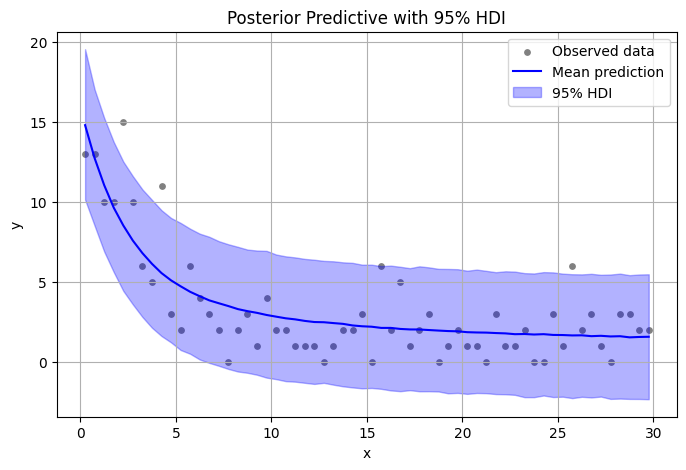

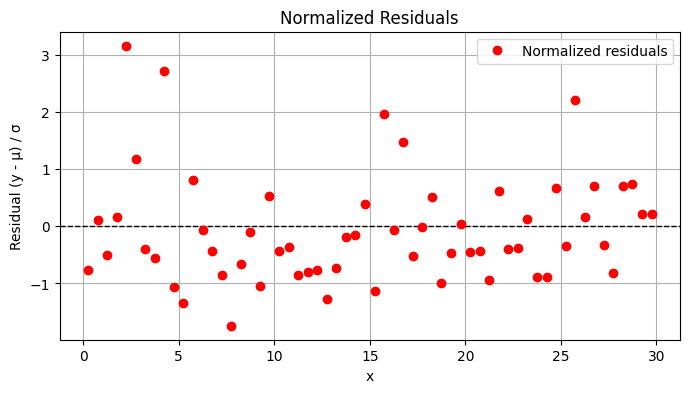

In [73]:
# Posterior Predictive Sampling
ppc = pm.sample_posterior_predictive(trace37Na, model=model, progressbar=False)
y_pred_samples = ppc.posterior_predictive['y_obs'].stack(draws=("chain", "draw")).values.T


# Compute summary stats
y_mean = np.mean(y_pred_samples, axis=0)
y_std = np.std(y_pred_samples, axis=0)
y_hdi_lower, y_hdi_upper = np.percentile(y_pred_samples, [2.5, 97.5], axis=0)

# -----------------------------
# 📈 Figure 1: Posterior Predictive Plot
# -----------------------------
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(decay_x, decay_y, color='grey', s=15, label='Observed data')
ax1.plot(decay_x, y_mean, color='blue', label='Mean prediction')
ax1.fill_between(decay_x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')
ax1.set_title('Posterior Predictive with 95% HDI')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid(True)

# -----------------------------
# 📉 Figure 2: Normalized Residuals
# -----------------------------
residuals = (decay_y - y_mean) / y_std

fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.plot(decay_x, residuals, marker='o', linestyle='', color='red', label='Normalized residuals')
ax2.set_title('Normalized Residuals')
ax2.set_xlabel('x')
ax2.set_ylabel('Residual (y - μ) / σ')
ax2.grid(True)
ax2.legend()

plt.show()


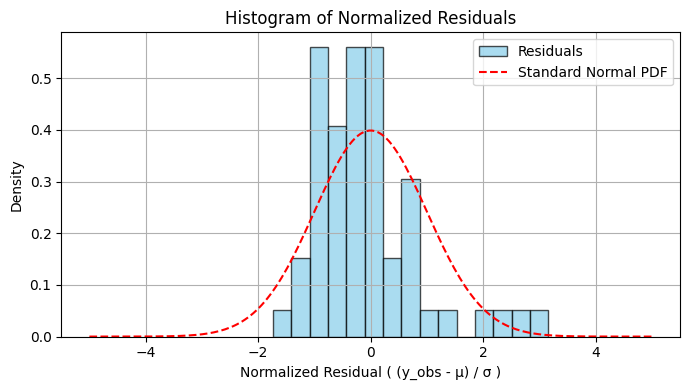

In [74]:

# Already computed earlier:
# residuals = (decay_y - y_mean) / y_std

# 1D histogram of residuals
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=15, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Residuals')

# Plot a standard normal distribution for comparison
from scipy.stats import norm
x_vals = np.linspace(-5, 5, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'r--', label='Standard Normal PDF')

plt.title("Histogram of Normalized Residuals")
plt.xlabel("Normalized Residual ( (y_obs - μ) / σ )")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
ppc = pm.sample_posterior_predictive(trace37Na, model=model).posterior_predictive
y_pred = np.mean(ppc['y_obs'], axis=0)

y_mean = np.mean(y_pred, axis=0)

y_hdi_lower, y_hdi_upper = np.percentile(y_pred, [2.5, 97.5], axis=0)

# Plot the data points
plt.scatter(x, y, color='grey', label='Data')

# Plot the mean prediction
plt.plot(x, y_mean, color='blue', label='Mean Prediction')

# Plot the HDI intervals as error bars
plt.fill_between(x, y_hdi_lower, y_hdi_upper, color='blue', alpha=0.3, label='95% HDI')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

array([[<AxesSubplot:ylabel='daugh0nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh1nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh2nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='daugh3nT'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\nB0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nBranch\nBn'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSu

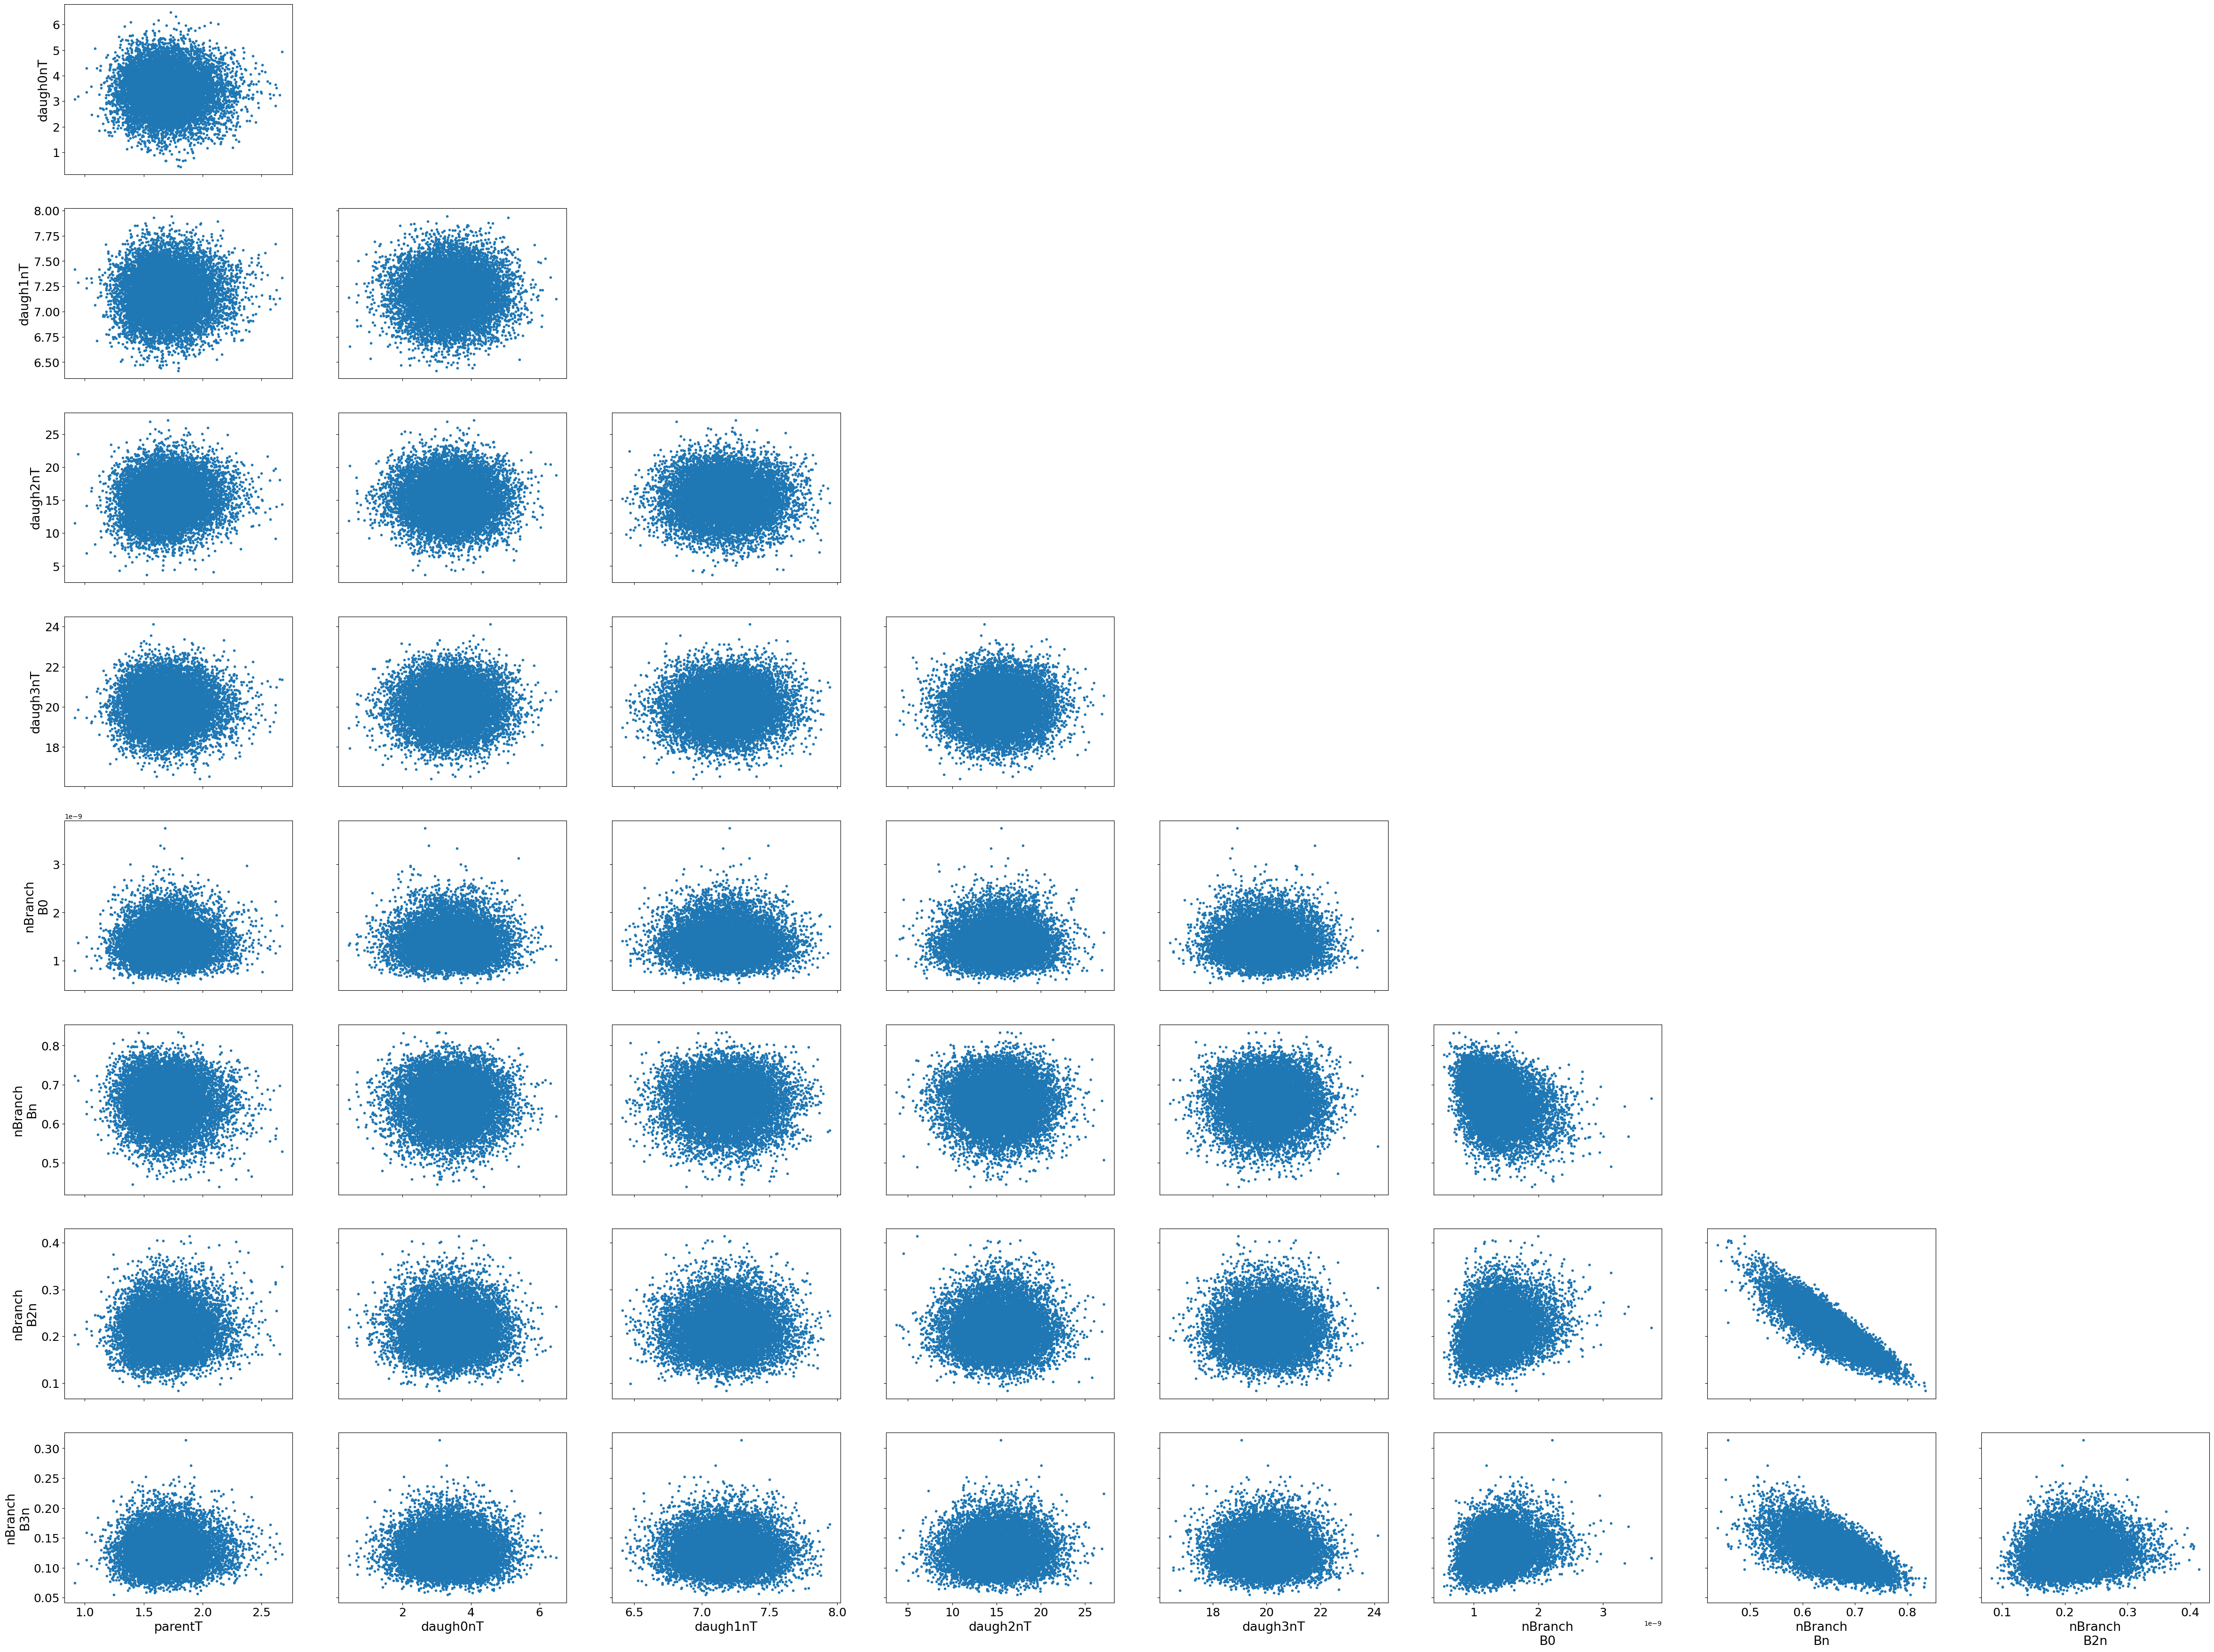

In [75]:
az.plot_pair(trace37Na, var_names=['parentT', 'daugh2nT', 'daugh3nT', 'daugh1nT', 'daugh0nT', 'nBranch'],
            filter_vars="regex",
            divergences=False,
            textsize=18)

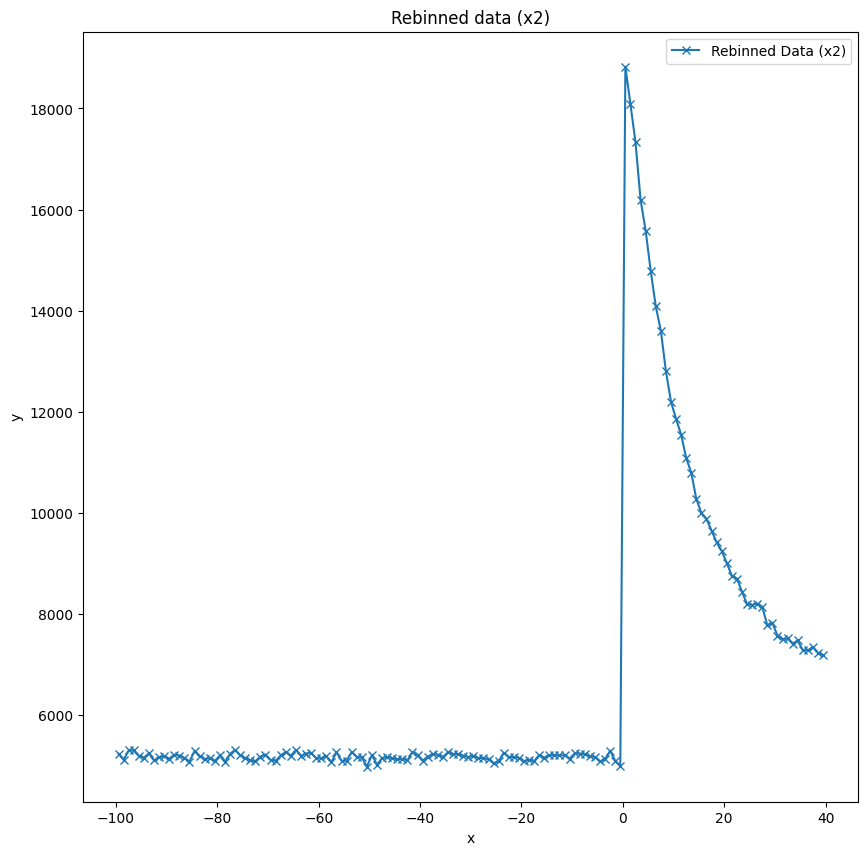

In [123]:
# Load and filter
df33Na = pd.read_csv('hist_33Na.csv')
df33Na = df33Na[(df33Na["xVal"] >= -100) & (df33Na["xVal"] <= 40)]

x = df33Na["xVal"].values
y = df33Na["yVal"].values

# Sort just in case
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Ensure even length (drop last point if needed)
if len(x) % 2 != 0:
    x = x[:-1]
    y = y[:-1]

# Rebin: average x every 2 points, sum y every 2 points
x_rebinned = x.reshape(-1, 2).mean(axis=1)
y_rebinned = y.reshape(-1, 2).sum(axis=1)

# Plot
fig33Na = plt.figure(figsize=(10, 10))
ax2 = fig33Na.add_subplot(111, xlabel="x", ylabel="y", title="Rebinned data (x2)")
ax2.plot(x_rebinned, y_rebinned, "x-", label="Rebinned Data (x2)")
ax2.legend()
plt.show()

In [127]:
decay_x = x[x >= 0]
decay_y = y[x >= 0]
with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=8.2, sigma=0.2*100)
    daughter0nThalf = pm.Normal('daugh0nT', mu=90.2, sigma=0.9)
    daughter1nThalf = pm.Normal('daugh1nT', mu=80.4, sigma=0.4)
    daughter2nThalf = pm.Normal('daugh2nT', mu=270, sigma=2)
    daughter3nThalf = pm.Normal('daugh3nT', mu=314, sigma=5)
    initialActivity = pm.Normal('initialActivity', mu=19000, sigma=1000)
    #branch0n = pm.Uniform('branch0n', 0., 0.1)
    #branch1n = pm.Uniform('branch1n', 0., (1.-branch0n))
    #branch2n = pm.Uniform('branch2n', 0., (1.-branch0n-branch1n))
    #branch3n = pm.Normal('branch3n', mu=(1.-branch0n-branch1n-branch2n), sigma=0.01)
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    nBranch = pm.Dirichlet('nBranch', [1., 1., 1., 1.])
    backgroundLevel = pm.Uniform('backgroundLevel', 0., 50.)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of the outcome
    mu = parent3nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, daughter3nThalf, nBranch[0], nBranch[1], nBranch[2], nBranch[3], backgroundLevel, decay_x)
 
    # Likelihood (sampling distribution) of the observations
    y_obs33Na = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=decay_y)
    #model.debug()
    
    # Run the MCMC sampling
    trace33Na = pm.sample(100, tune=100)

 
# Plot the posterior distributions

pm.plot_posterior(trace33Na, var_names=['initialActivity', 'parentT', 'daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT', 'nBranch', 'backgroundLevel'])
plt.show()

TypeError: parent3nDaughterLinear() takes 11 positional arguments but 12 were given

Only 100 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 64 jobs)
NUTS: [bkg_amp, bkg_lambda, sigma_bkg]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 0 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.75, but should be close to 0.995. Try to increase the number of tuning steps.
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1119: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  FutureWarning,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1128: UserWarning: Softmax no longer converts a vector to a row matrix.
  UserWarning,
Only 100 samples in chain.


0.08570229266024394 0.05012147543013313


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 64 jobs)
NUTS: [parentT, daugh0nT, daugh1nT, daugh2nT, daugh3nT, initialActivity, theta, bkg_amp, bkg_lambda, sigma]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6321, but should be close to 0.995. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6374, but should be close to 0.995. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


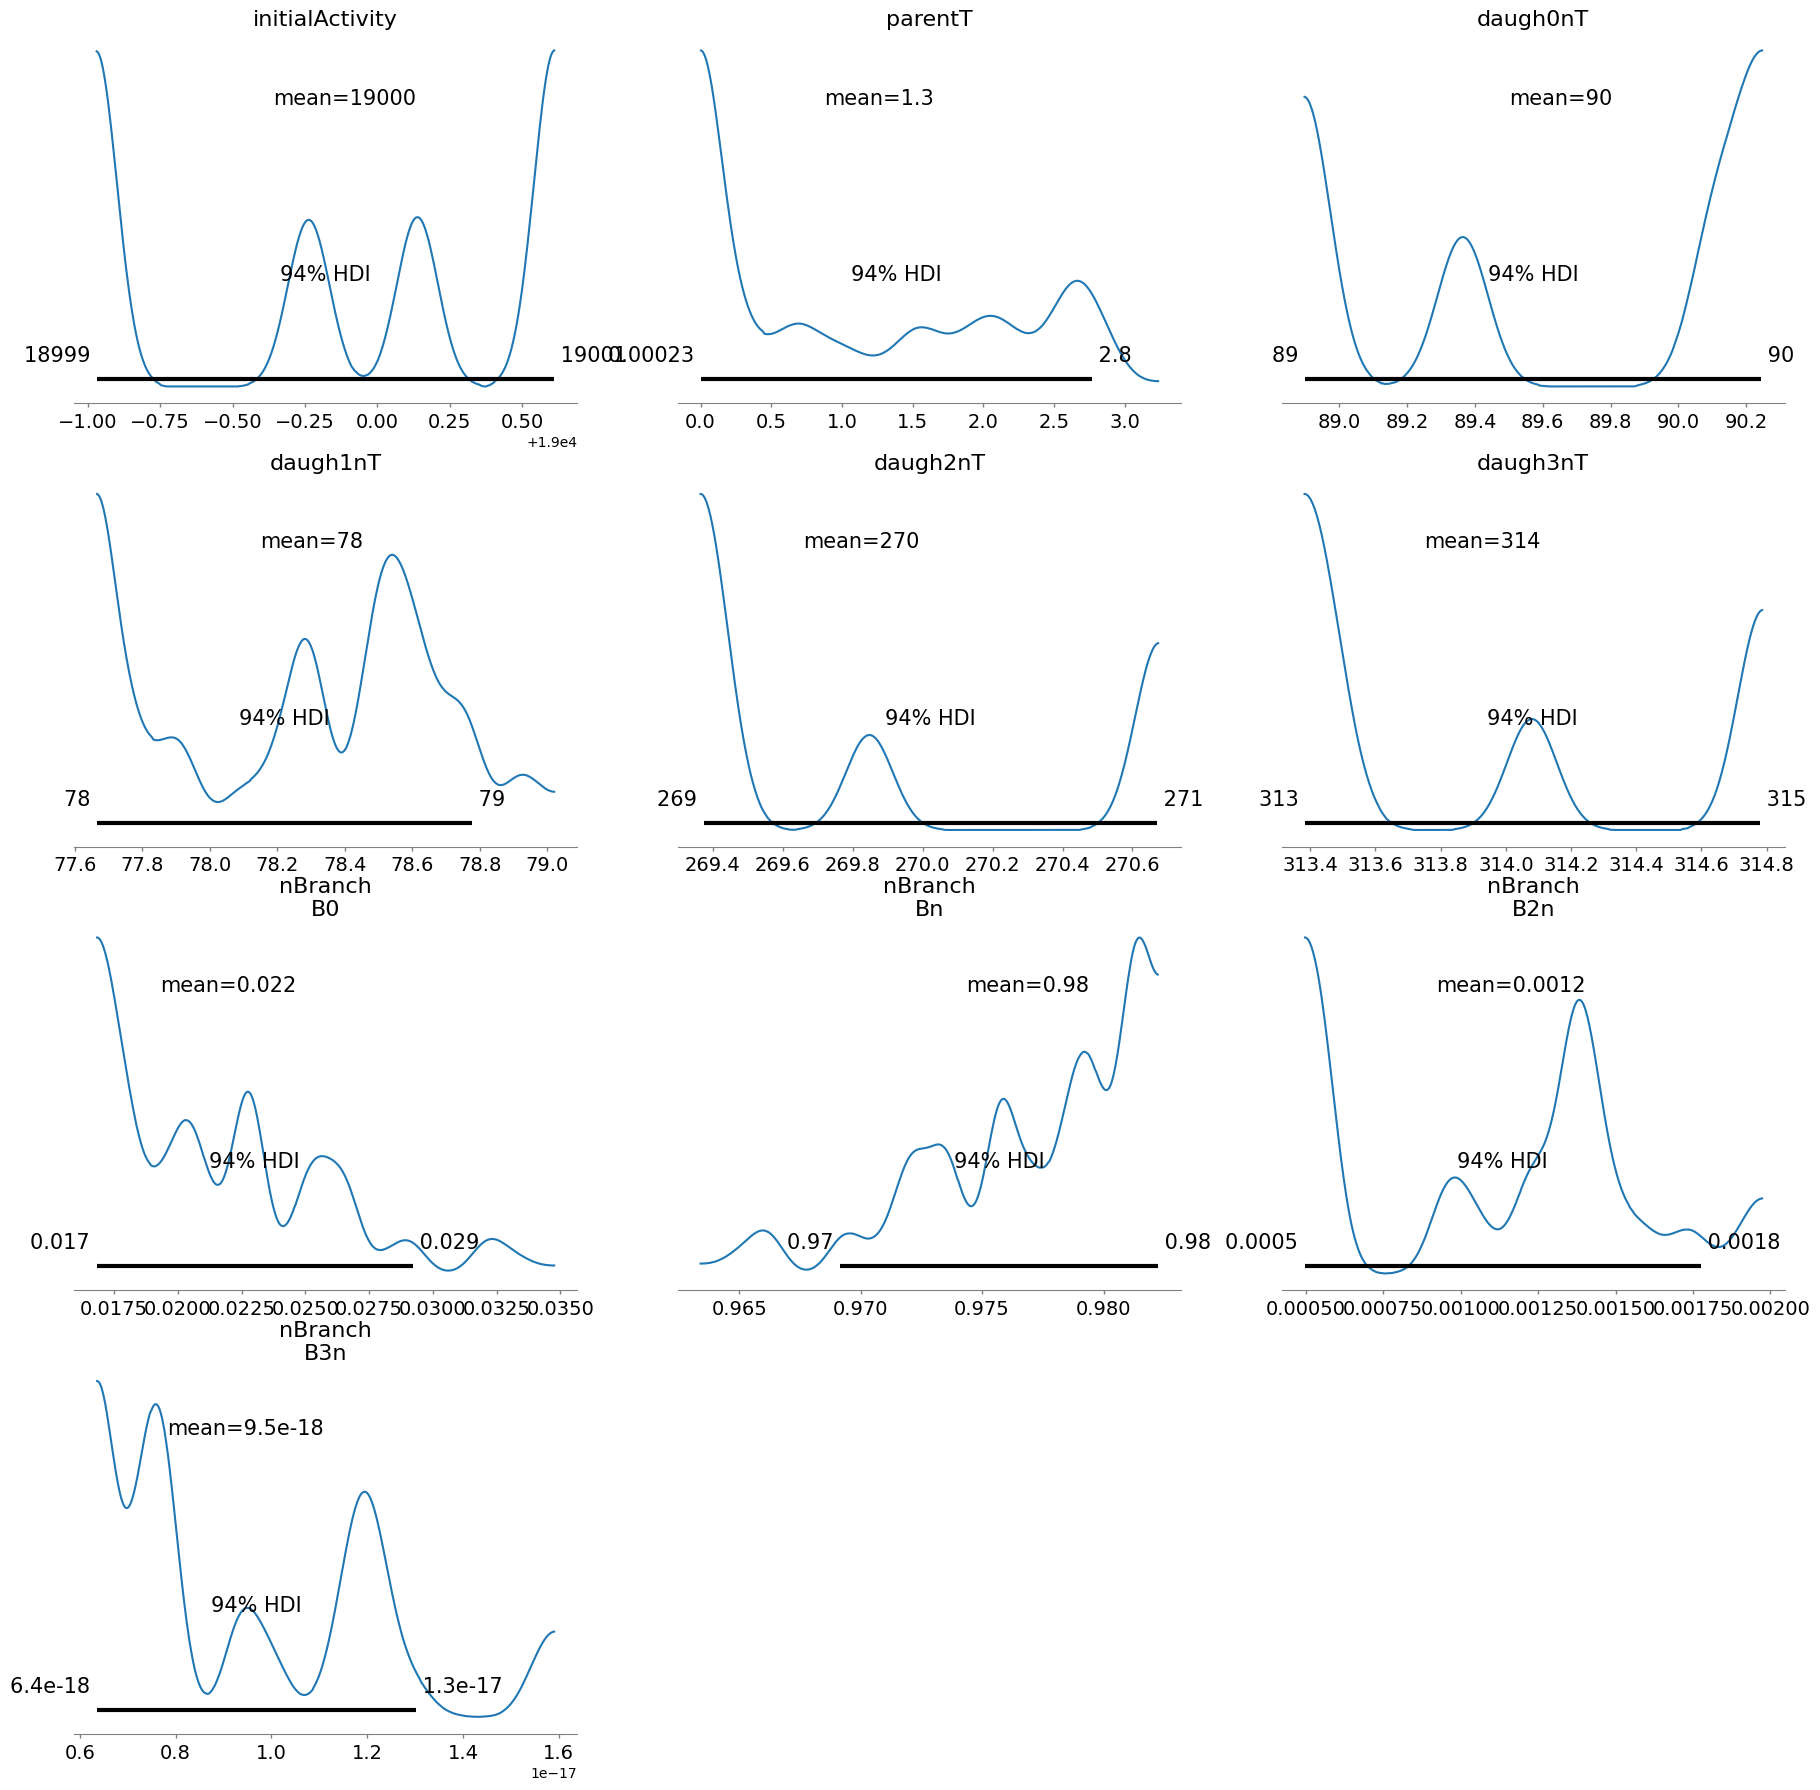

In [128]:
import multiprocessing
import aesara.tensor as at


# Split data
pre_x = x[x < 0]
pre_y = y[x < 0]
decay_x = x[x >= 0]
decay_y = y[x >= 0]

# --- Step 1: Fit background model on pre-decay region ---
with pm.Model() as bkg_model:
    bkg_amp = pm.Normal('bkg_amp', sigma=500)
    bkg_lambda = pm.Normal('bkg_lambda', sigma=0.1)

    bkg_mu = bkg_amp * pm.math.exp(bkg_lambda * pre_x)

    sigma_bkg = pm.Normal('sigma_bkg', sigma=5)
    y_bkg_obs = pm.Normal('y_bkg_obs', mu=bkg_mu, sigma=sigma_bkg, observed=pre_y)

    trace_bkg = pm.sample(100, tune=100, target_accept=0.995, chains=4, cores=multiprocessing.cpu_count() )

# Extract background fit means
bkg_amp_mean = np.mean(trace_bkg.posterior['bkg_amp'].stack(draws=("chain", "draw")).values)
bkg_lambda_mean = np.mean(trace_bkg.posterior['bkg_lambda'].stack(draws=("chain", "draw")).values)

# --- Step 2: Define decay model + exponential background ---

# Define the total decay function (no background inside!)
def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n,
                           branch0n, branch1n, branch2n, branch3n, x):
    return (
        parent(t_parent, a0, x)
        + daughter0n(t_daugh0n, t_parent, a0, branch0n, x)
        + daughter1n(t_daugh1n, t_parent, a0, branch1n, x)
        + daughter2n(t_daugh2n, t_parent, a0, branch2n, x)
        + daughter3n(t_daugh3n, t_parent, a0, branch3n, x)
    )

with pm.Model() as model:
    # Priors for decay and activity
    parentThalf = pm.Normal('parentT', mu=8.2, sigma=0.2*100)
    daughter0nThalf = pm.Normal('daugh0nT', mu=90.2, sigma=0.9)
    daughter1nThalf = pm.Normal('daugh1nT', mu=80.4, sigma=0.4)
    daughter2nThalf = pm.Normal('daugh2nT', mu=270, sigma=2)
    daughter3nThalf = pm.Normal('daugh3nT', mu=314, sigma=5)
    initialActivity = pm.Normal('initialActivity', mu=19000, sigma=1000)

    # Branching ratios
    #nBranch = pm.Dirichlet('nBranch', [1e-16, 0.6, 0.2, 0.2])
    #theta = pm.Normal('theta', mu=0, sigma=0.2, shape=4)
    #nBranch = pm.Deterministic('nBranch', at.nnet.softmax(theta))
    target_softmax = np.array([0.4, 0.47,0.13,1e-16])
    theta_mu = np.log(target_softmax)
    theta = pm.Normal('theta', mu=theta_mu, sigma=0.2, shape=4)
    nBranch = pm.Deterministic('nBranch', at.nnet.softmax(theta))
    #nBranch = pm.Dirichlet('nBranch', [0.4, 0.47, 0.13, 1e-16])

    # Background with priors from previous fit
    bkg_amp = pm.Normal('bkg_amp', mu=bkg_amp_mean, sigma=500)
    bkg_lambda = pm.Normal('bkg_lambda', mu=bkg_lambda_mean, sigma=0.1)
    print(bkg_amp_mean, bkg_lambda_mean)
    background = pm.Deterministic('background', bkg_amp_mean * pm.math.exp(-bkg_lambda_mean * decay_x))

    # Decay model
    decay_mu = parent3nDaughterLinear(
        initialActivity,
        parentThalf,
        daughter0nThalf,
        daughter1nThalf,
        daughter2nThalf,
        daughter3nThalf,
        nBranch[0], nBranch[1], nBranch[2], nBranch[3],
        decay_x
    )

    # Total model
    mu = pm.Deterministic('mu', decay_mu + background)

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Likelihood
    y_obs33a = pm.Poisson('y_obs', mu=mu, observed=decay_y)

    # Sampling
    trace33Na = pm.sample(100, tune=100, target_accept=0.995, chains=4, cores=multiprocessing.cpu_count())
trace33Na = trace33Na.assign_coords(nBranch_dim_0=["B0", "Bn", "B2n", "B3n"])
pm.plot_posterior(trace33Na, var_names=['initialActivity','parentT','daugh0nT', 'daugh1nT', 'daugh2nT', 'daugh3nT','nBranch'])
plt.show()
